In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os
import glob

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report

from seaborn import clustermap
import matplotlib.pyplot as plt

import plotly.express as px

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from modules.hmm import get_hits, get_seqs

In [3]:

import seaborn as sns
sns.set(font_scale=0.25)

In [31]:
DATA_DIR = "../data/runs/aquificota/2024-09-29/"

SOURCES = ["barosa"]

E_VALUE_THR = 1e-5
ABSENCE_THR = 0.90
CORE_THR    = 0.75

CLUSTERMAP_METHOD = "ward"
CLUSTERMAP_METRIC = "braycurtis"

RANDOM_SEED = 666

## Raw data

In [5]:
hits_path = os.path.join(
    DATA_DIR,
    "HighQ_Aquificota_Sequences_AA_hmmer.txt"
)
seqs_path = os.path.join(
    DATA_DIR,
    "HighQ_Aquificota_Sequences_AA.fa"
)

hits_df = get_hits(hits_path)
seqs_df = get_seqs(seqs_path)

hits_df = pd.merge(
    left=hits_df,
    right=seqs_df.rename(columns={"seq_id": "target_name"}),
    how="left",
    on="target_name"
)

# Create MAG and gene caller ID columns
hits_df["mag"] = hits_df["target_name"]\
    .str.split("_").str[:-1]\
    .apply(lambda row: "_".join(row))
hits_df["gene_caller_id"] = hits_df["target_name"]\
    .str.split("_").str[-1]

hits_df

target_name target_accession  \
0           Persephonella_sp_M17_metabat2_scaf2bin_002_257                -   
1           Persephonella_sp_A1_metabat2_scaf2bin_131_1263                -   
2                   Aquificota_bacterium_L_MetaBat_11_1112                -   
3        Hydrogenothermaceae_bacterium_134_614_metabat2...                -   
4        Hydrogenothermaceae_bacterium_S141_maxbin2_sca...                -   
...                                                    ...              ...   
1250276  Aquificaceae_bacterium_T2_maxbin2_scaf2bin_342...                -   
1250277           Aquificaceae_bacterium_S141_87_esom_1070                -   
1250278  Aquificaceae_bacterium_354_166_metabat1_scaf2b...                -   
1250279  Persephonella_sp_PIR_30_metabat2_scaf2bin_079_...                -   
1250280                 Aquificaceae_bacterium_MAG_13_1250                -   

                              query_name query_accession  e_value_full_seq  \
0        baker_rubisco_form_IV_alignment               -     8.700000e-108   
1        baker_rubisco_form_IV_alignment               -     1.800000e-107   
2        baker_rubisco_form_IV_alignment               -     1.700000e-104   
3        baker_rubisco_form_IV_alignment               -     4.500000e-104   
4        baker_rubisco_form_IV_alignment               -      4.400000e-85   
...                                  ...             ...               ...   
1250276          metascan_WP_013516312.1       KO:K17052      1.300000e-10   
1250277          metascan_WP_013516312.1       KO:K17052      1.100000e-09   
1250278          metascan_WP_013516312.1       KO:K17052      1.300000e-06   
1250279          metascan_WP_013516312.1       KO:K17052      5.100000e-03   
1250280          metascan_WP_013516312.1       KO:K17052      6.400000e-03   

         score_full_seq  bias_full_seq  e_value_best_dom  score_best_dom  \
0                 364.4            0.0     9.800000e-108           364.3   
1                 363.4            0.0     2.000000e-107           363.2   
2                 353.6            0.0     1.900000e-104           353.4   
3                 352.2            0.0     5.000000e-104           352.1   
4                 289.7            0.0      4.900000e-85           289.5   
...                 ...            ...               ...             ...   
1250276            45.2            0.0      1.900000e-10            44.8   
1250277            42.3            0.4      1.300000e-09            42.0   
1250278            32.2            0.0      2.000000e-06            31.6   
1250279            20.4            0.0      5.800000e-03            20.2   
1250280            20.1            0.1      7.500000e-03            19.9   

         bias_best_dom  ...  clu  ov  env  dom  rep  inc  \
0                  0.0  ...    0   0    1    1    1    1   
1                  0.0  ...    0   0    1    1    1    1   
2                  0.0  ...    0   0    1    1    1    1   
3                  0.0  ...    0   0    1    1    1    1   
4                  0.0  ...    0   0    1    1    1    1   
...                ...  ...  ...  ..  ...  ...  ...  ...   
1250276            0.0  ...    0   0    1    1    1    1   
1250277            0.4  ...    0   0    1    1    1    1   
1250278            0.0  ...    0   0    1    1    1    1   
1250279            0.0  ...    0   0    1    1    1    1   
1250280            0.1  ...    0   0    1    1    1    1   

         description_of_target  \
0                            -   
1                            -   
2                            -   
3                            -   
4                            -   
...                        ...   
1250276                      -   
1250277                      -   
1250278                      -   
1250279                      -   
1250280                      -   

                                                       seq  \
0        MNYIEVTYLLTTKQHVDPEKKAEELAISLSIGGWGDLSENKRKNLE.

## Preprocessing

In [6]:
# Filter by selected source
hits_df = hits_df[hits_df["query_name"].str.startswith(tuple(SOURCES))]

# Filter by e-value threshold
hits_df = hits_df[hits_df["e_value_full_seq"] <= E_VALUE_THR]

# Get only those hits with the lowest E-value
hits_df = hits_df.loc[
    hits_df.groupby("target_name")["e_value_full_seq"].idxmin()
].reset_index(drop=True)

hits_df

target_name target_accession  \
0                         Aquifex_aeolicus_HyVt_501_1051                -   
1                         Aquifex_aeolicus_HyVt_501_1054                -   
2                         Aquifex_aeolicus_HyVt_501_1074                -   
3                         Aquifex_aeolicus_HyVt_501_1076                -   
4                         Aquifex_aeolicus_HyVt_501_1111                -   
...                                                  ...              ...   
20396  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
20397  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
20398  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
20399  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
20400  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   

                                 query_name query_accession  e_value_full_seq  \
0                barosa_fefe-group-c2.mafft               -      6.700000e-22   
1                barosa_fefe-group-c2.mafft               -      5.600000e-06   
2                barosa_fefe-group-c2.mafft               -      5.900000e-13   
3                barosa_fefe-group-c2.mafft               -      1.400000e-31   
4                             barosa_K21308               -     2.000000e-106   
...                                     ...             ...               ...   
20396                      barosa_TIGR02891       TIGR02891     5.100000e-173   
20397                      barosa_TIGR02866       TIGR02866      4.900000e-48   
20398                         barosa_K02299               -      4.700000e-26   
20399  barosa_PirA-siderophore_receptor-rep               -      9.500000e-06   
20400                         barosa_FeoB_N      PF02421.13      6.200000e-09   

       score_full_seq  bias_full_seq  e_value_best_dom  score_best_dom  \
0                81.7            6.0      8.400000e-22            81.4   
1                29.1            0.0      9.400000e-06            28.4   
2                52.2            0.7      7.800000e-13            51.8   
3               113.8           61.4      2.200000e-17            66.8   
4               359.3            5.8     2.300000e-106           359.2   
...               ...            ...               ...             ...   
20396           580.3           44.0     5.900000e-173           580.1   
20397           167.3            3.7      7.200000e-48           166.7   
20398            95.7           21.3      4.700000e-26            95.7   
20399            28.2            0.0      1.300000e-05            27.8   
20400            39.5            0.2      2.700000e-08            37.4   

       bias_best_dom  ...  clu  ov  env  dom  rep  inc  description_of_target  \
0                6.0  ...    0   0    1    1    1    1                      -   
1                0.0  ...    0   0    1    1    1    1                      -   
2                0.7  ...    0   0    1    1    1    1                      -   
3               27.6  ...    1   1    2    2    2    2                      -   
4                5.8  ...    0   0    1    1    1    1                      -   
...              ...  ...  ...  ..  ...  ...  ...  ...                    ...   
20396           44.0  ...    0   0    1    1    1    1                      -   
20397            3.7  ...    0   0    1    1    1    1                      -   
20398           21.3  ...    1   0    1    1    1    1                      -   
20399            0.0  ...    0   0    1    1    1    1                      -   
20400            0.2  ...    1   0    1    1    1    1                      -   

                                                     seq  \
0      MFTKGEDTERQEERMEGAELENLKREVERLREELRTKDEECERLRR...   
1      MKALRKSFRLKVTLAFLIVGLIPYVIFSLFSIAQMEKALRERIEYD...   
2      MAKVKGEEFLRLTKMIANTAQATSEFLSDSCLVDLDEIFGNVLNKL...   
3      MKEILPPQESGAARRAMSGANQRRRERTSAKKQALVEK

#### Saving sequences for each HMM

In [7]:
sequences_dir = os.path.join(
    DATA_DIR,
    "sequences"
)
os.makedirs(sequences_dir, exist_ok=True)

for hmm_model in hits_df["query_name"].unique():

    hmm_path = os.path.join(
        sequences_dir,
        f"{hmm_model}.fasta"
    )

    hmm_df = hits_df[hits_df["query_name"] == hmm_model]

    hmm_seqs = [
        SeqRecord(
            Seq(row["seq"]),
            id=row["target_name"],
            name="",
            description="",
        )
        for _, row in hmm_df.iterrows()
    ]

    SeqIO.write(hmm_seqs, hmm_path, "fasta")


#### Creating the heatmap dataframe

In [8]:
# Presence/abscence (remove for having the counts of many-vs-many)
heat_df = hits_df[["mag", "query_name"]].copy()

heat_df = heat_df.rename(columns={"query_name": "profile"})
heat_df = heat_df\
    .value_counts()\
    .reset_index(drop=False)\
    .rename(columns={0: "count"})

# Add collumn for displaying presence/absence
heat_df["presence"] = heat_df["count"].apply(lambda row: int(bool(row)))

# Filter profiles
heat_df["source"] = heat_df["profile"].str.split("_").str[0]

heat_df = heat_df.pivot(
    index="mag",
    columns="profile",
    values="presence"
)

# Format columns
heat_df.columns = heat_df.columns.str.replace("barosa.source.hmm_", "barosa_")

# Fill NaNs
heat_df = heat_df.fillna(0.0)

heat_df

profile                                             barosa_Cyc1  \
mag                                                               
Aquifex_aeolicus_HyVt_501                                   0.0   
Aquifex_aeolicus_SZUA_1413                                  0.0   
Aquifex_aeolicus_SZUA_1501                                  0.0   
Aquifex_aeolicus_SZUA_1519                                  0.0   
Aquifex_aeolicus_VF5                                        0.0   
...                                                         ...   
Thermovibrio_sp_S012_127_esom                               0.0   
Thermovibrio_sp_S141_83                                     0.0   
Venenivibrio_stagnispumantis_DSM_18763                      0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...          0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...          0.0   

profile                                             barosa_Cyc2_repCluster1  \
mag                                                                           
Aquifex_aeolicus_HyVt_501                                               1.0   
Aquifex_aeolicus_SZUA_1413                                              0.0   
Aquifex_aeolicus_SZUA_1501                                              0.0   
Aquifex_aeolicus_SZUA_1519                                              0.0   
Aquifex_aeolicus_VF5                                                    0.0   
...                                                                     ...   
Thermovibrio_sp_S012_127_esom                                           0.0   
Thermovibrio_sp_S141_83                                                 0.0   
Venenivibrio_stagnispumantis_DSM_18763                                  0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...                      0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...                      0.0   

profile                                             barosa_Cyc2_repCluster2  \
mag                                                                           
Aquifex_aeolicus_HyVt_501                                               0.0   
Aquifex_aeolicus_SZUA_1413                                              0.0   
Aquifex_aeolicus_SZUA_1501                                              0.0   
Aquifex_aeolicus_SZUA_1519                                              0.0   
Aquifex_aeolicus_VF5                                                    0.0   
...                                                                     ...   
Thermovibrio_sp_S012_127_esom                                           0.0   
Thermovibrio_sp_S141_83                                                 0.0   
Venenivibrio_stagnispumantis_DSM_18763                                  0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...                      0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...                      0.0   

profile                                             barosa_Cyc2_repCluster3  \
mag                                                                           
Aquifex_aeolicus_HyVt_501                                               0.0   
Aquifex_aeolicus_SZUA_1413                                              0.0   
Aquifex_aeolicus_SZUA_1501                                              0.0   
Aquifex_aeolicus_SZUA_1519                                              0.0   
Aquifex_aeolicus_VF5                                                    0.0   
...                                                                     ...   
Thermovibrio_sp_S012_127_esom                                           0.0   
Thermovibrio_sp_S141_83                                                 0.0   
Venenivibrio_stagnispumantis_DSM_18763                                  0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...                      0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...                      0.0   

profile                                     

#### Creating the heatmap annotations

In [9]:
# Get correct HMM model name mapping

hmm_mapping = {}

for hmm_path in glob.glob("../data/profiles/barosa/*.hmm"):
    hmm_filename = os.path.basename(hmm_path)

    with open(hmm_path, mode="r") as handle:
        hmm_name = handle.readlines()[1]\
            .replace("NAME  ", "")\
            .replace("\n", "")

        hmm_mapping[hmm_filename] = hmm_name

hmm_mapping

{'FbpC-iron_uptake_ATPase-rep.hmm': 'FbpC-iron_uptake_ATPase-rep',
 'nife-group-3c.hmm': 'nife-group-3c.mafft',
 'nitrite_reductase_nirS.hmm': 'nirS_alignment',
 'K19713.hmm': 'K19713',
 'K05919.hmm': 'K05919',
 'PF02335.hmm': 'PF02335_full',
 'IroC-salmochelin_transport-rep.hmm': 'IroC-salmochelin_transport-rep',
 'methylenetetrahydrofolate_dehydrogenase.hmm': 'PRK14186.1',
 'rubisco_form_I_CBB.hmm': 'rubisco_form_I_alignment',
 'sulfide_quinone_oxidoreductase_sqr.hmm': 'sqr_alignment',
 'TIGR02294_1.hmm': 'nickel_nikA',
 'assimilatory_nitrate_reductase_nasA.hmm': 'assimilatory_nitrate_reductase_nasA.hmm',
 '2_oxoglutarate_synthase.hmm': 'PRK09627.1',
 'Sid_FpvG_iron_reductase_PA2403_Paeruginosa_PAO1_180602.hmm': 'Sid_FpvG_iron_reductase_PA2403_Paeruginosa_PAO1_180602',
 'TIGR02882.hmm': 'TIGR02882',
 'wpA.hmm': 'PRK04168.1',
 'OmcZ.hmm': 'OmcZ',
 'TIGR02930.hmm': 'TIGR02930',
 'asrA.hmm': 'TIGR02910',
 'pmoB.hmm': 'K10945',
 'FoxZ.hmm': 'FoxZ',
 'FmnB.hmm': 'FmnB',
 'sulfocyanin.hmm'

In [10]:
metadata_df = pd.read_excel(
    os.path.join(
        "../data/",
        "Aquificota_Revised_Biogeochem_genes.xlsx"
    ),
    sheet_name="Revised_biogeochem",
    engine="openpyxl"
)

metadata_df = metadata_df\
    .dropna(how="all", axis=0)\
    .dropna(how="all", axis=1)

# Fix HMM names
metadata_df = metadata_df.rename(columns={"hmm model": "hmm_model"})
metadata_df["hmm_model"] = metadata_df["hmm_model"].map(hmm_mapping)

# Format cycle column
metadata_df["Cycle"] = metadata_df["Cycle"].str.strip()

# Format HMM column to fit file format
metadata_df["hmm_model"] = metadata_df["hmm_model"]\
    .apply(lambda row: f"barosa_{row.replace('.hmm', '')}")

metadata_df["cycle_colors"] = metadata_df["Cycle"].map({
    "Arsenic": "#e8c5aaff",
    "Carbon": "#75a56bff",
    "Methane": "#e8dfe2ff",
    "Nitrogen": "#386b9aff",
    "Oxygen": "#b9a3cbff",
    "Photosynthesis": "#7fd68bff",
    "Sulfur": "#edd970ff",
    "Hydrogen": "#8EC3E6",
    "Iron": "#861f2bff",
    "Selenium": "#a78873ff",
    "Transporters": "#F4A261"
})
cycle_colors = metadata_df\
    .set_index("hmm_model")["cycle_colors"]\
    .rename("Cycle")
cycle_colors

hmm_model
barosa_arsC_glut                                                                                  #e8c5aaff
barosa_arsC_thio                                                                                  #e8c5aaff
barosa_arxA                                                                                       #e8c5aaff
barosa_aioA                                                                                       #e8c5aaff
barosa_K03520                                                                                     #75a56bff
                                                                                                    ...    
barosa_Sid_LbtC_Legiobactin_PAP2_superfamily_Legionella_oakridgensis_AHE65915.1_180604            #861f2bff
barosa_Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_180623                                       #861f2bff
barosa_Sid_VabS_Vanchrobactin_Export_Vibrio_anguillarum_CAJ45638.1_180623                         #861f2bff
barosa_Sid_YqjH_NA

In [11]:
tax_df = pd.read_csv(
    os.path.join(
        "../data/",
        "Aquificota_gtdb_classification.csv"
    )
)
tax_df["Genomes"] = tax_df["Genomes"].str.split("\\td__").str[0]
tax_df["Family"] = tax_df["Family"].str.split("__").str[-1]
tax_df["family_colors"] = tax_df["Family"].map({
    "Aquificaceae": "#f0ba7cff",
    "Desulfurobacteriaceae": "#E07A5F",
    "DSM-5069": "white",
    "Hydrogenothermaceae": "#81B29A",
    "QOAS01": "#3D405B",
    "Thermotogaceae": "white"
})
family_colors = tax_df\
    .set_index("Genomes")["family_colors"]\
    .rename("Family")
family_colors

Genomes
Aquifex_aeolicus_HyVt_501                                     #f0ba7cff
Aquifex_aeolicus_SZUA_1413                                    #f0ba7cff
Aquifex_aeolicus_SZUA_1501                                      #3D405B
Aquifex_aeolicus_SZUA_1519                                      #3D405B
Aquifex_aeolicus_VF5                                          #f0ba7cff
                                                                ...    
Thermovibrio_sp_S012_127_esom                                   #E07A5F
Thermovibrio_sp_S141_83                                         #E07A5F
Venenivibrio_stagnispumantis_DSM_18763                          #81B29A
unclassified_Aquificaceae_Obs3_genome_041_Obs3_genome_041     #f0ba7cff
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN__048_sub_1    #f0ba7cff
Name: Family, Length: 175, dtype: object

## Global clustermaps

In [33]:
core_hmms = heat_df.columns[
    (heat_df == 1).mean() >= CORE_THR
]
heat_df[core_hmms].columns.tolist()

['barosa_DmkB',
 'barosa_FbpC-iron_uptake_ATPase-rep',
 'barosa_FeoA',
 'barosa_FeoB_N',
 'barosa_FeoE',
 'barosa_FutC-iron_ABC_transporter_ATPase-rep',
 'barosa_IroC-salmochelin_transport-rep',
 'barosa_K00030',
 'barosa_K01681',
 'barosa_K20140',
 'barosa_K21308',
 'barosa_MDH_euk_gproteo',
 'barosa_PF00593-TonB_dependent_receptor-PiuA-PirA-FepA-RhtA',
 'barosa_PRK00696.1',
 'barosa_PRK08395.1',
 'barosa_PRK09231.1',
 'barosa_PRK14186.1',
 'barosa_PorA_Arch',
 'barosa_TIGR02374',
 'barosa_TIGR02911',
 'barosa_aclA_alignment',
 'barosa_cbiO',
 'barosa_corA',
 'barosa_fadh2',
 'barosa_fefe-group-a13.mafft',
 'barosa_mgtE',
 'barosa_nickel_nikA',
 'barosa_nife-group-4a-g.mafft',
 'barosa_sqr_alignment',
 'barosa_sulfur_dioxygenase_sdo_alignment']

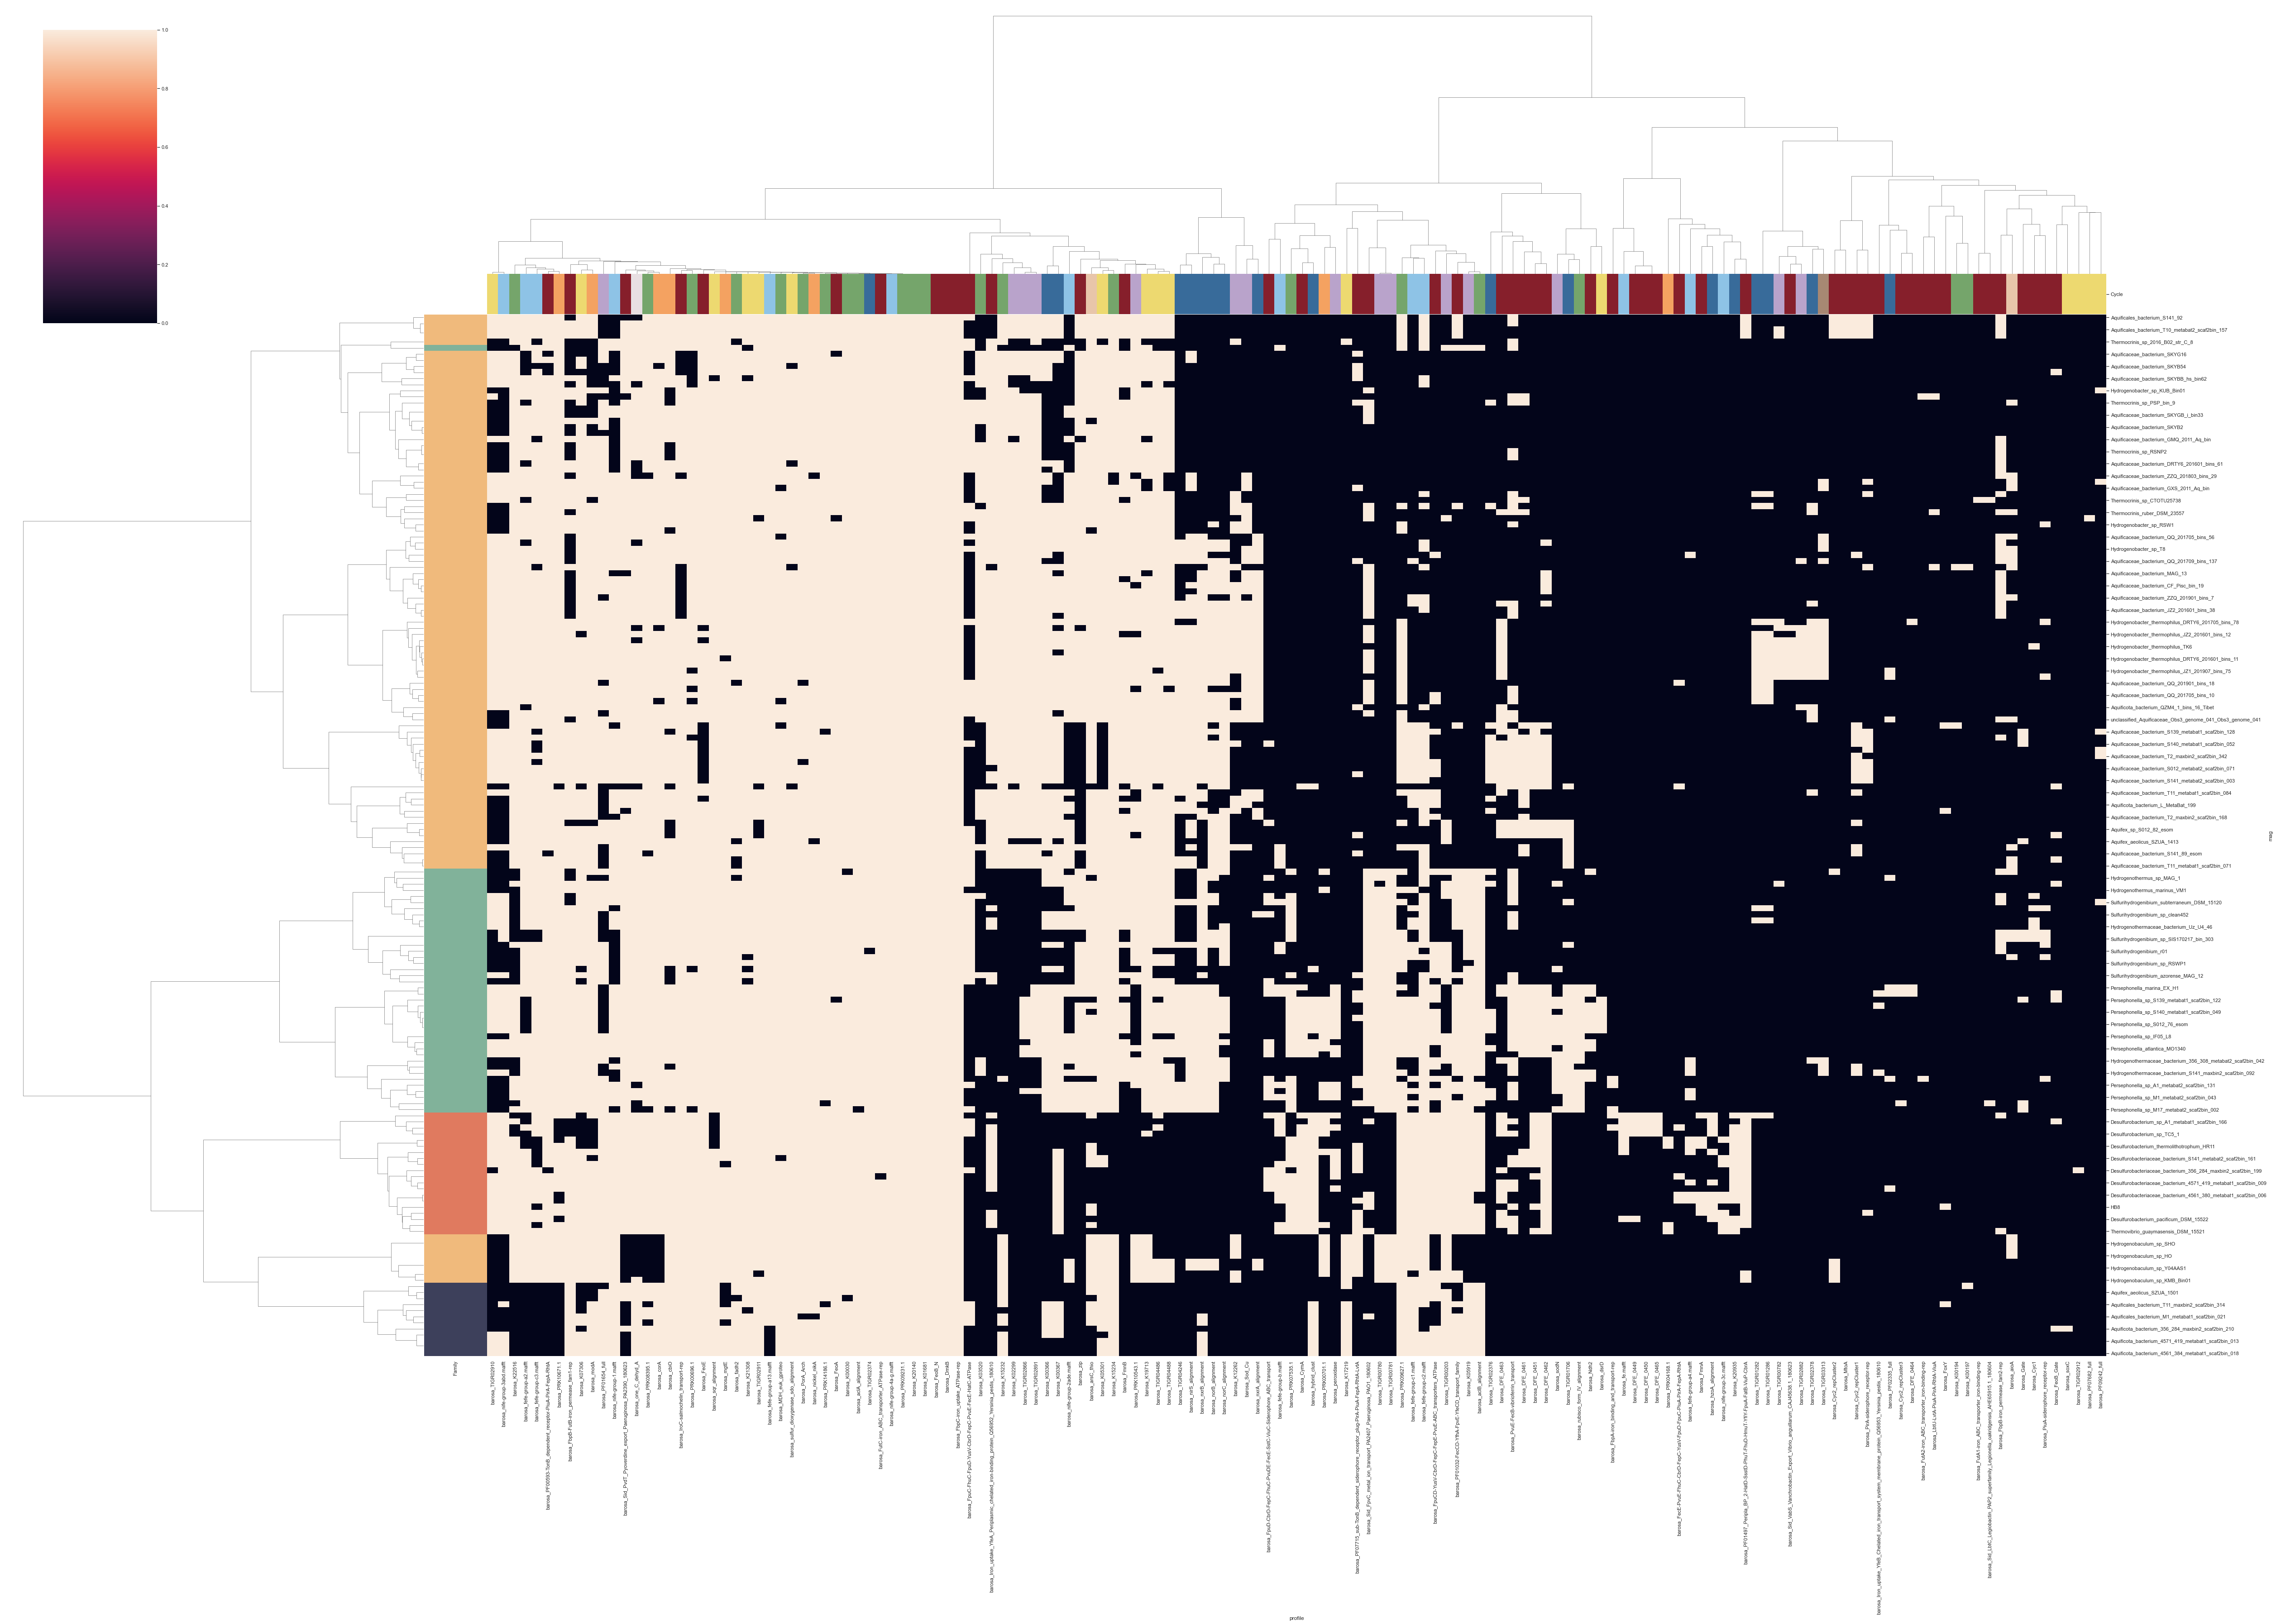

In [21]:
clustermap(
    data=heat_df,
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-complete.svg"
    ),
    dpi=300
)

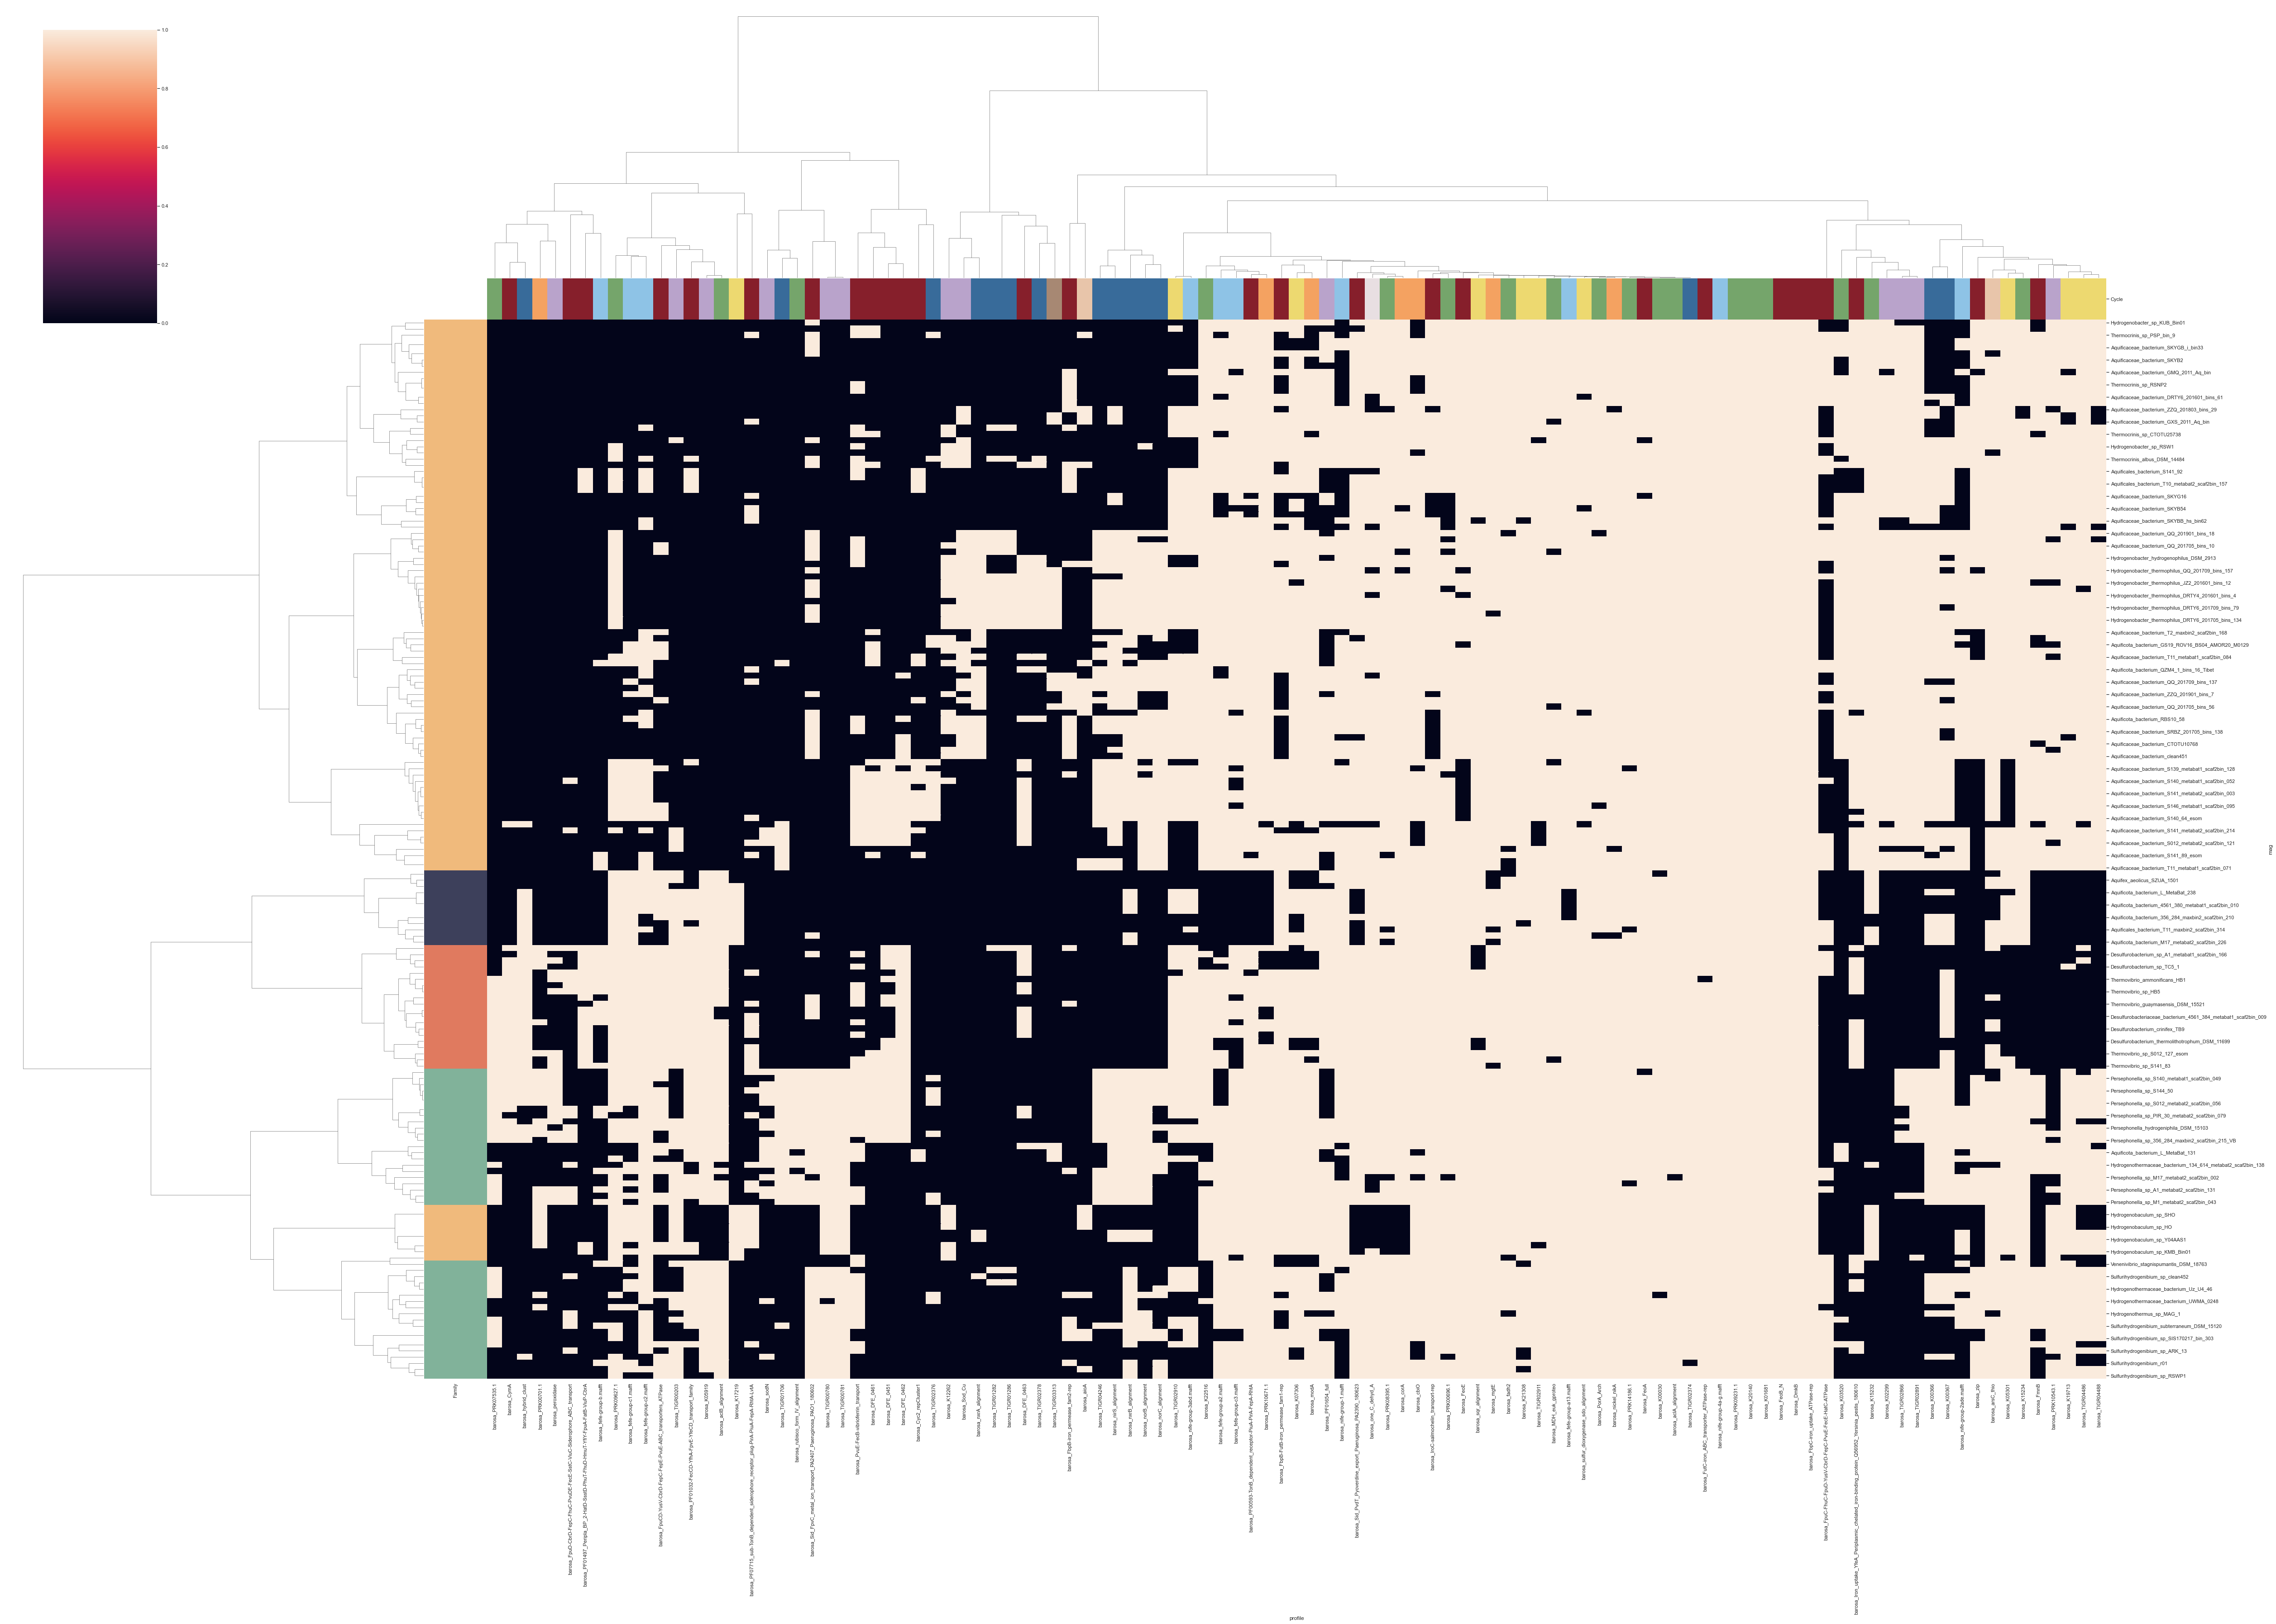

In [22]:
# Select columns that contain less that a proportion of zeroes
non_zero_columns = heat_df.columns[
    (heat_df == 0).mean() <= ABSENCE_THR
]
heat_df_nonzero = heat_df[non_zero_columns]

clustermap(
    data=heat_df_nonzero,
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-nonzero.svg"
    ),
    dpi=300
)

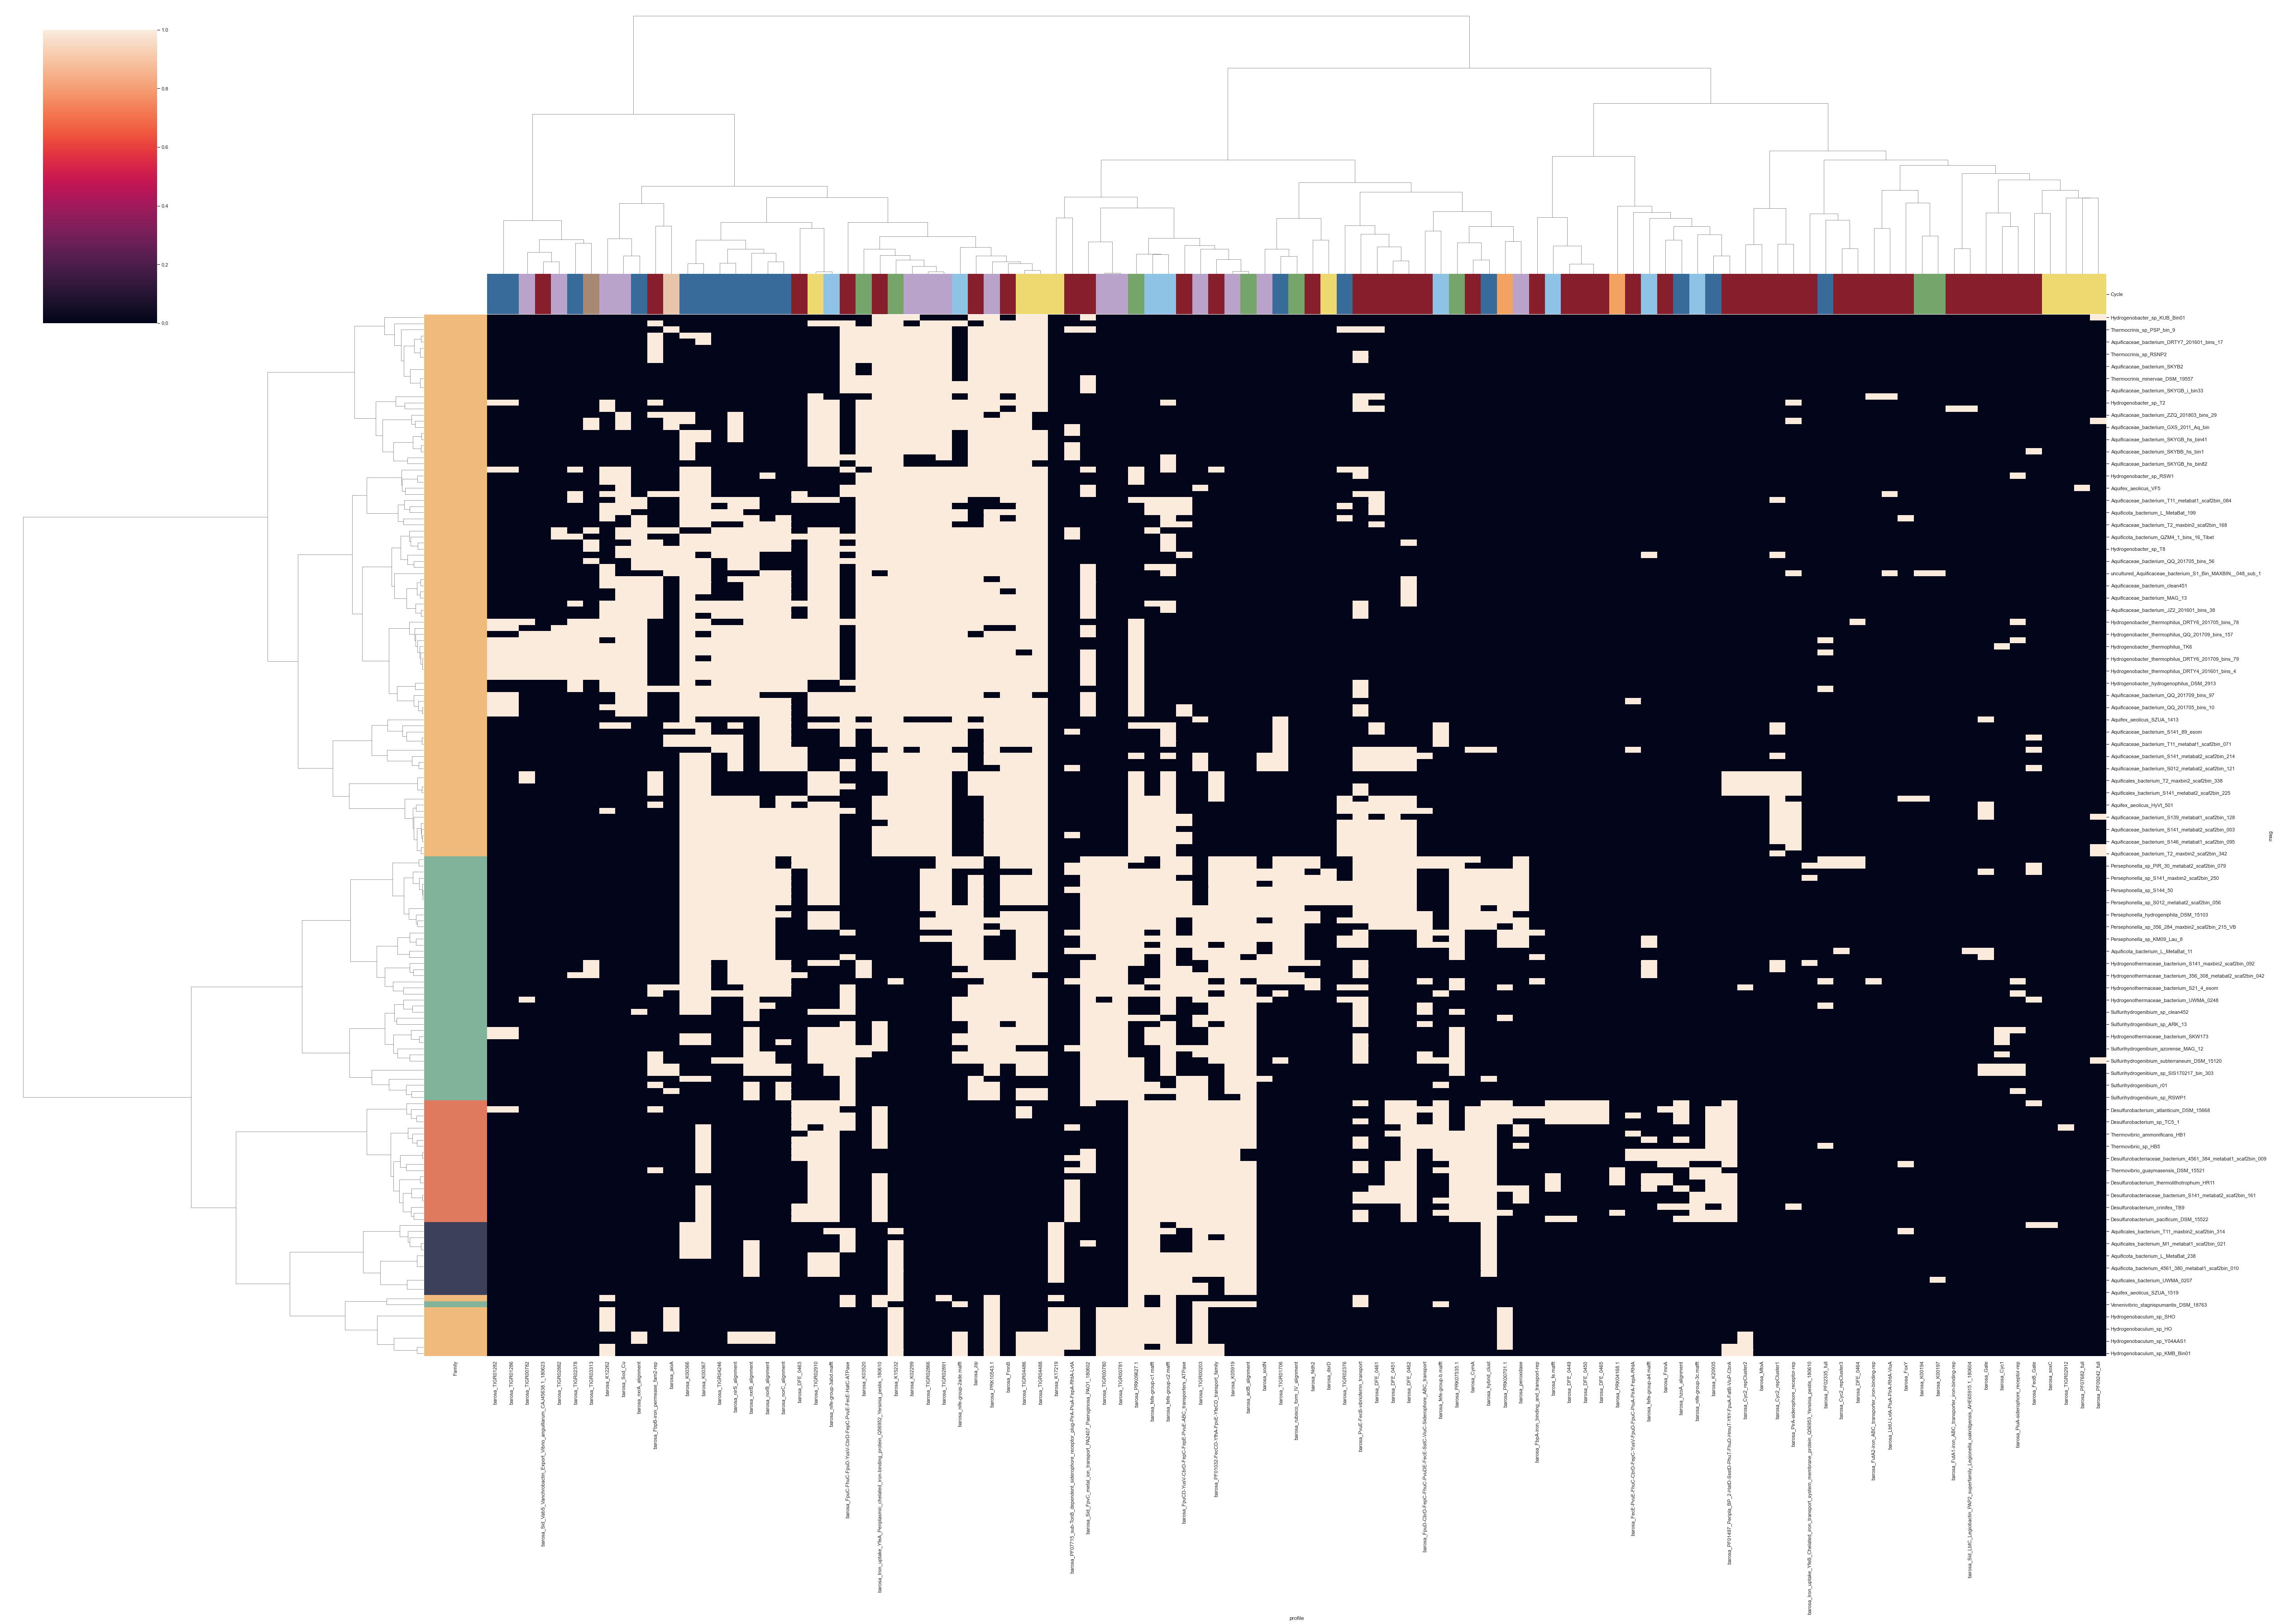

In [37]:
clustermap(
    data=heat_df.drop(core_hmms, axis=1),
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-accessory.svg"
    ),
    dpi=300
)

## Cycles clustermaps

[+] Clustermap for cycle Arsenic
[ERROR] Could not create clustermap for cycle Arsenic: NaN dissimilarity value.
[+] Clustermap for cycle Carbon


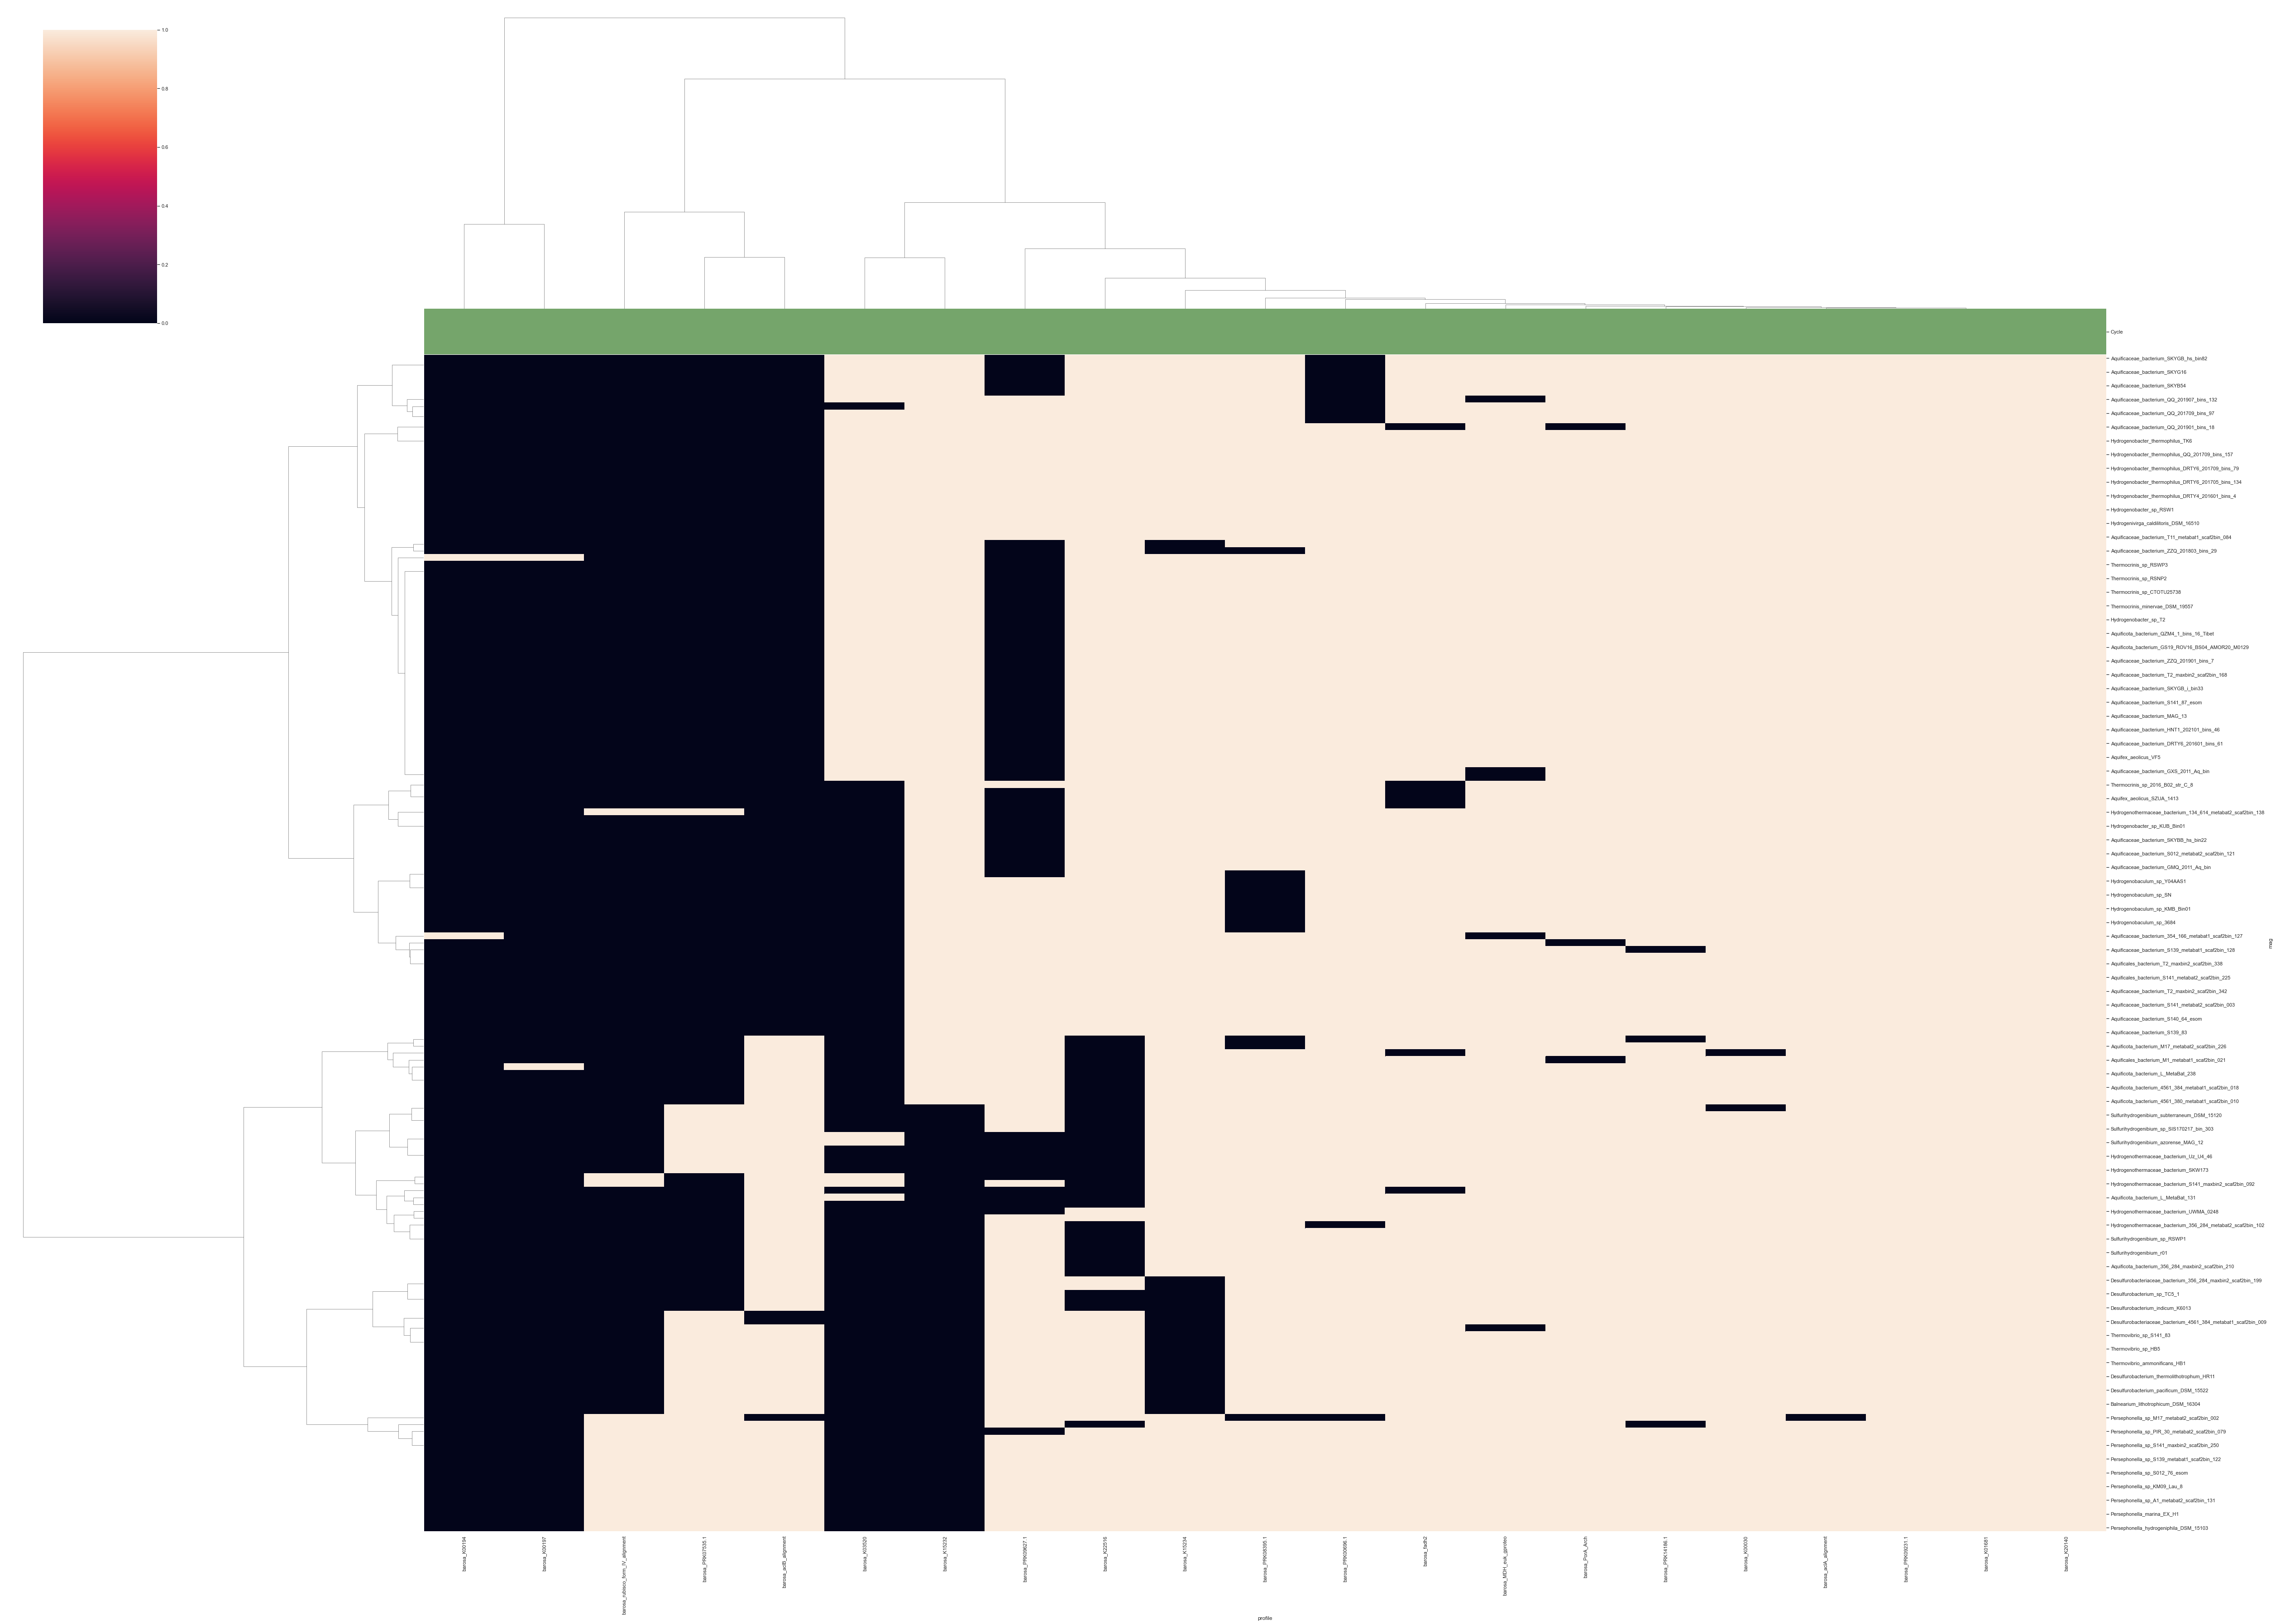

[+] Clustermap for cycle Methane
[ERROR] Could not create clustermap for cycle Methane: NaN dissimilarity value.
[+] Clustermap for cycle Nitrogen


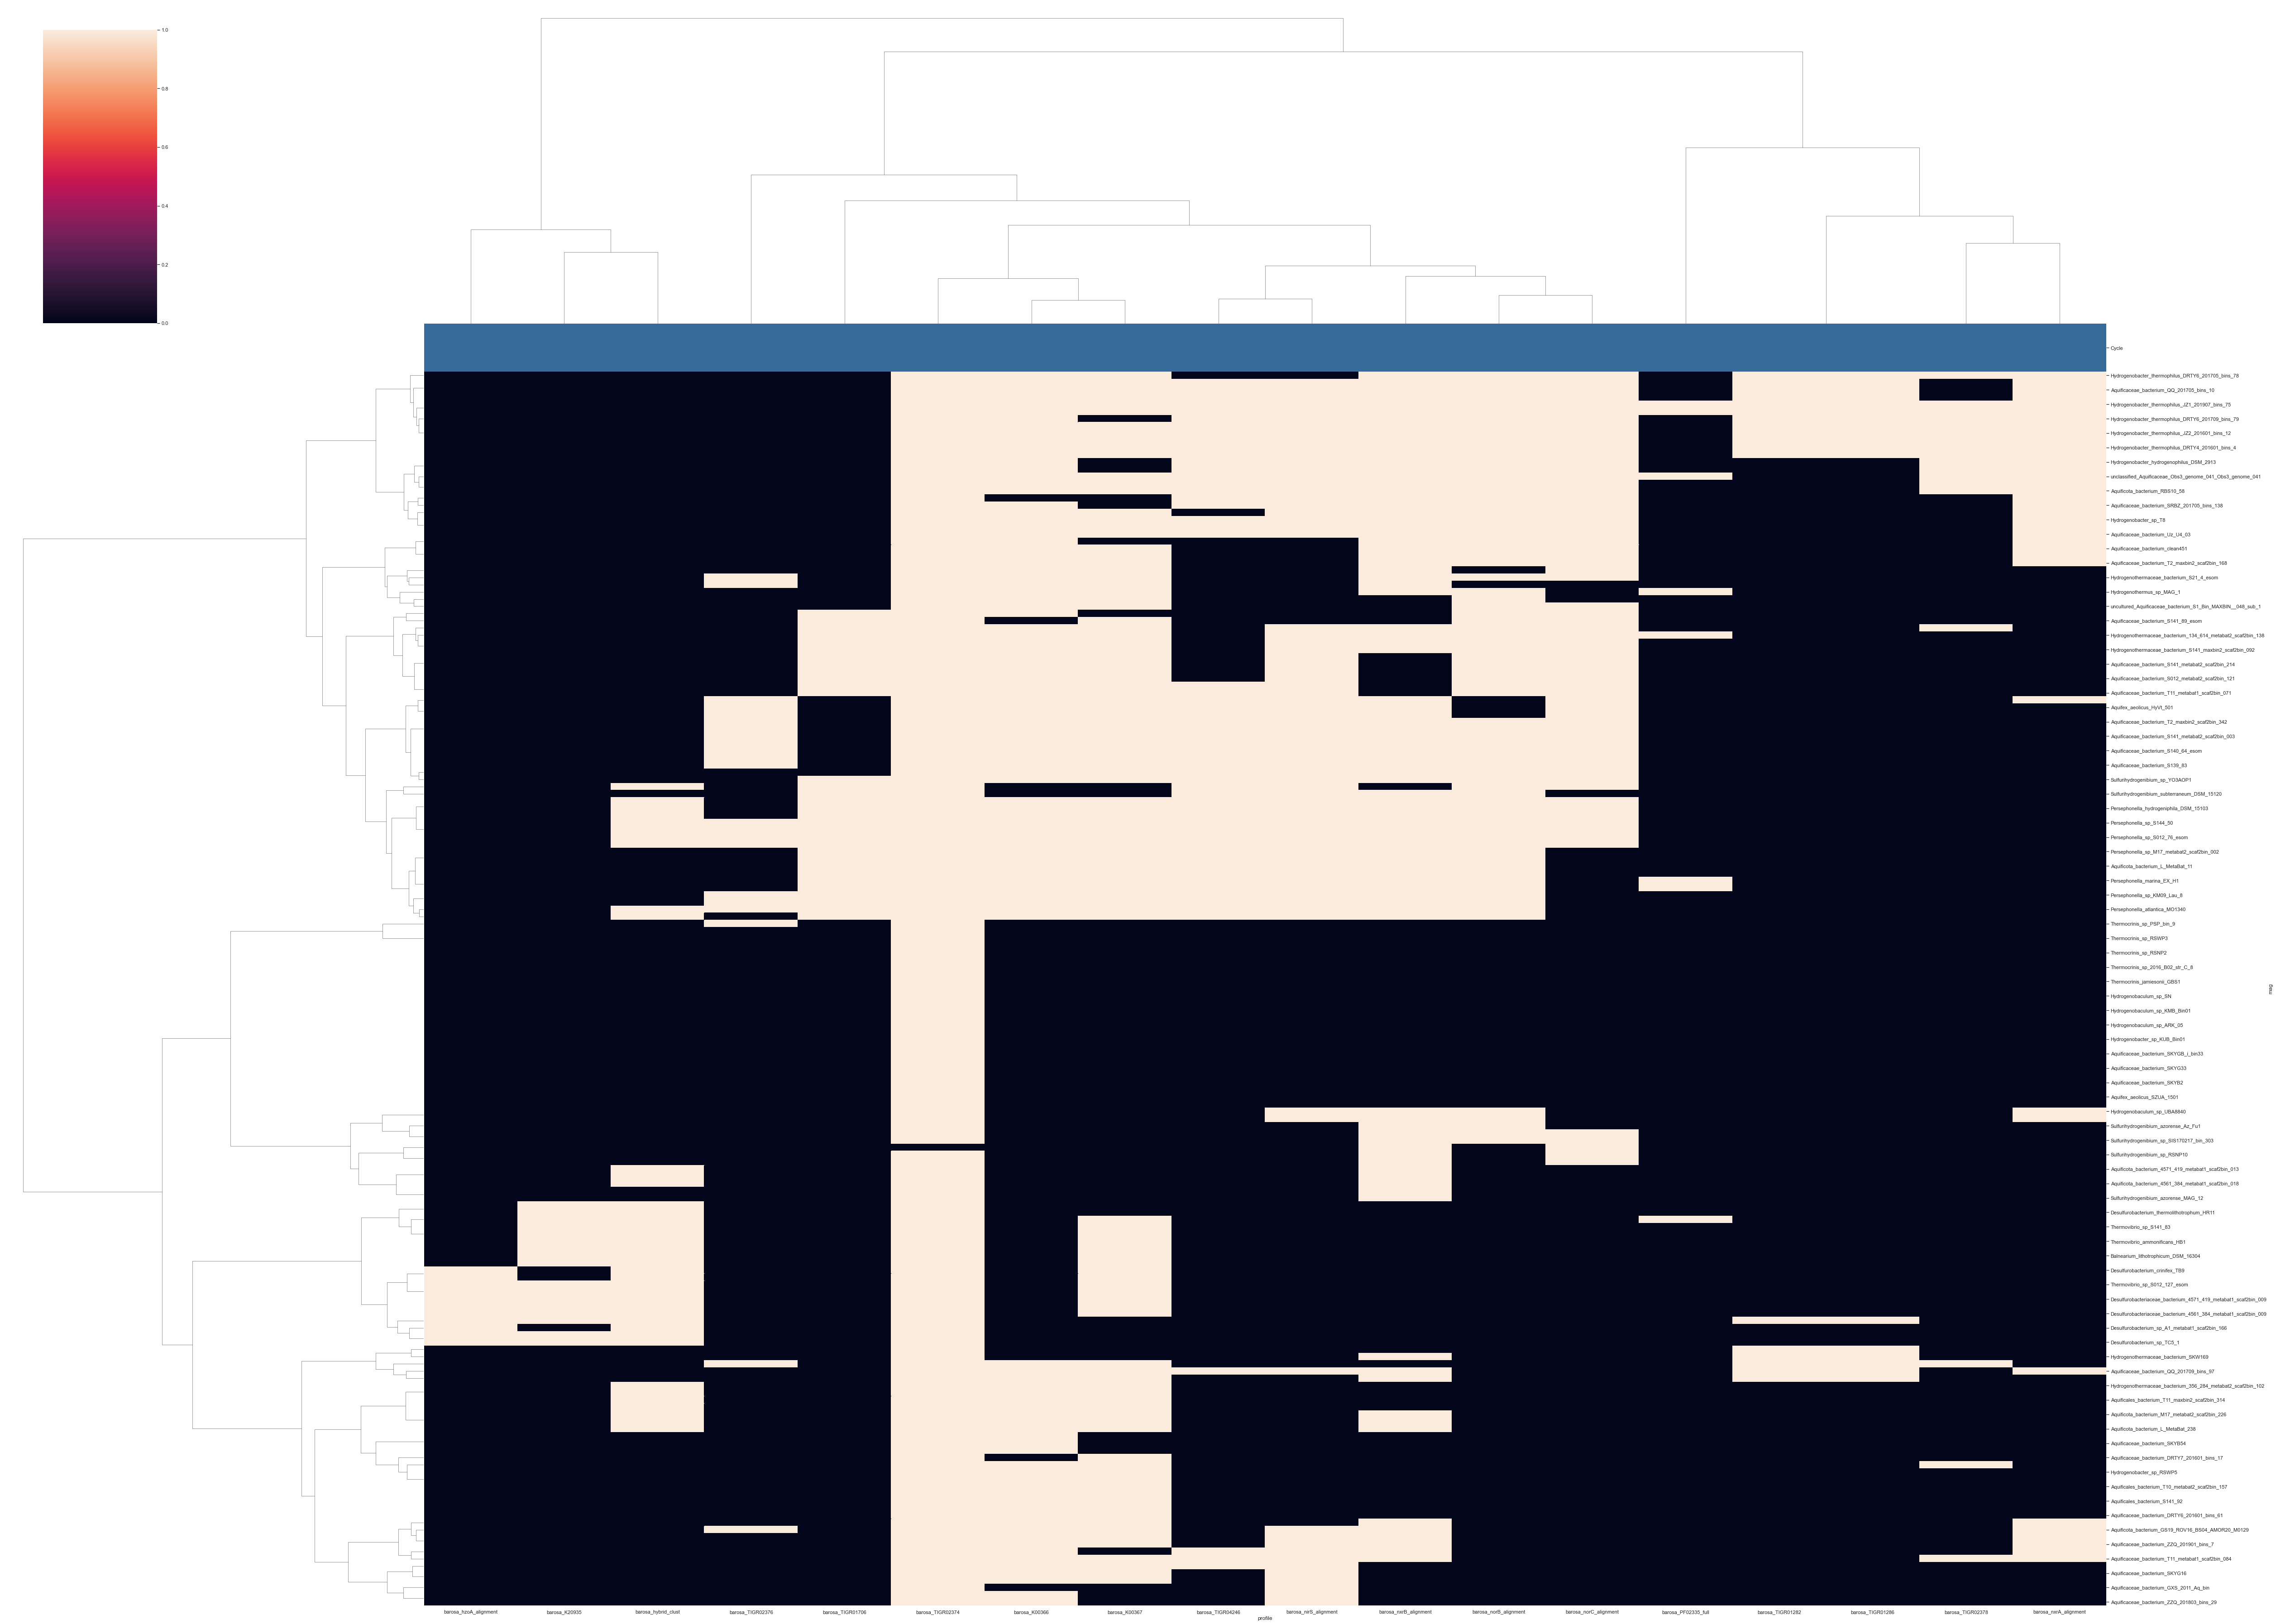

[+] Clustermap for cycle Oxygen


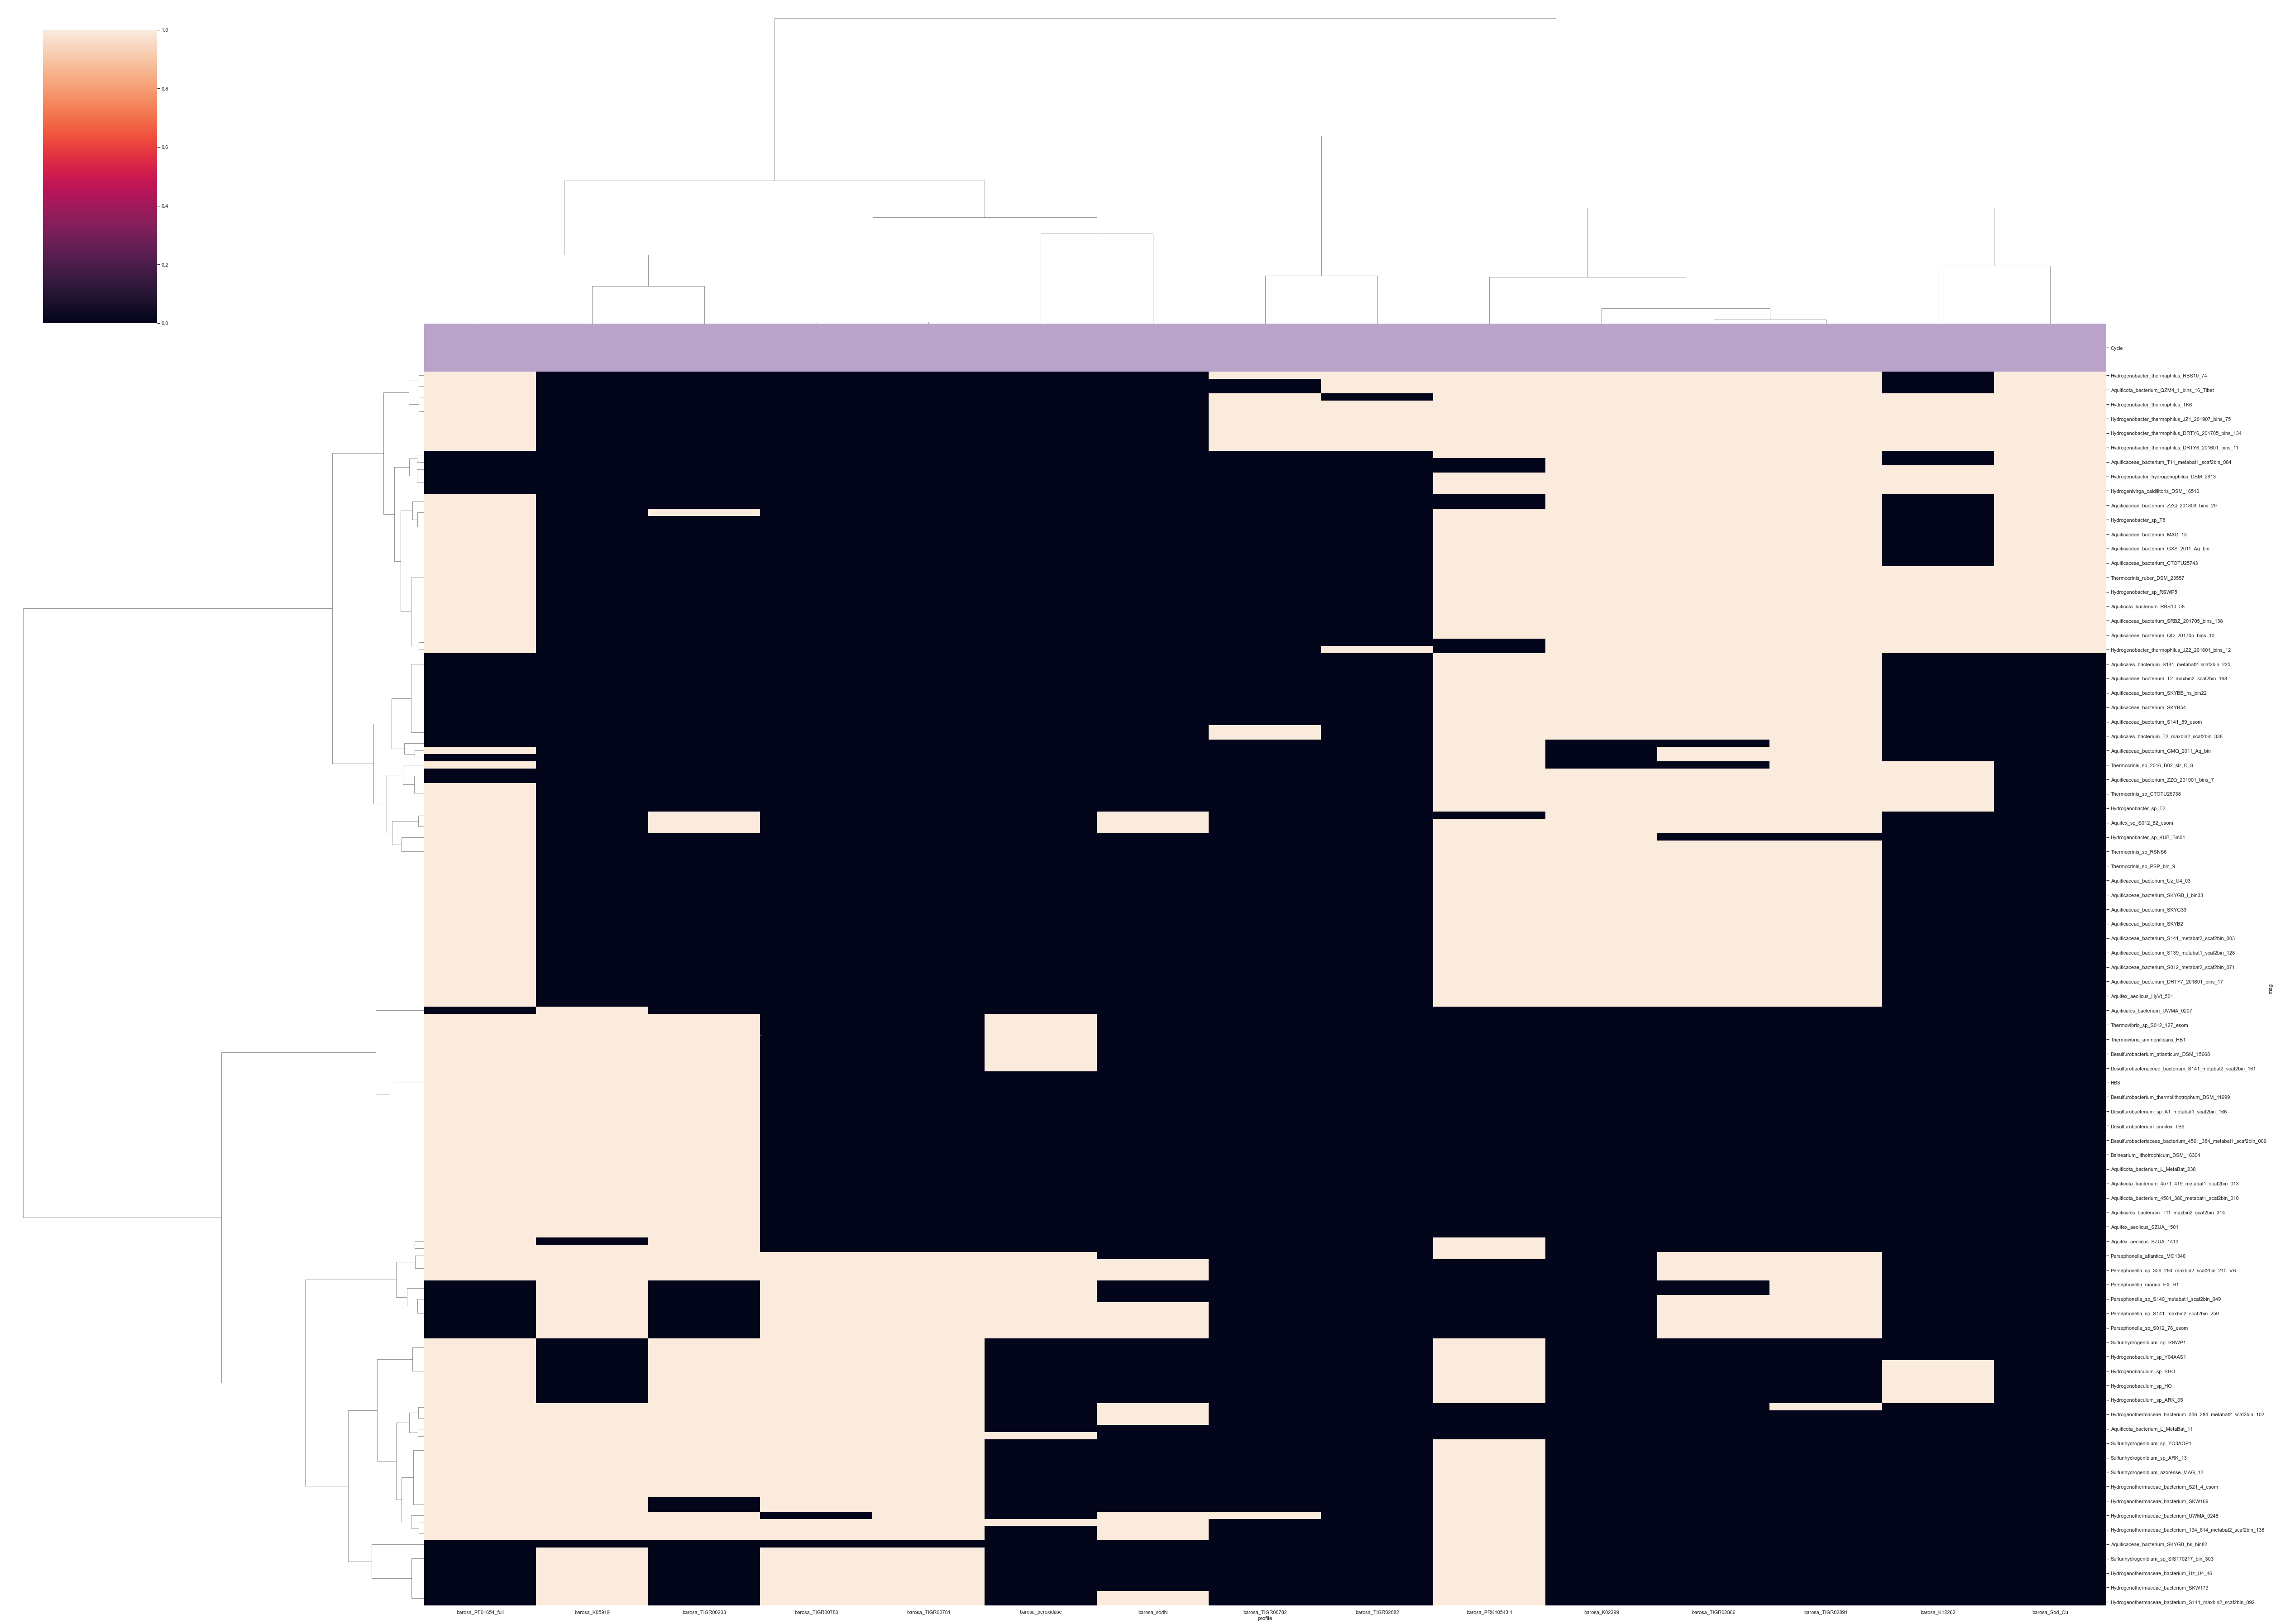

[+] Clustermap for cycle Photosynthesis
[ERROR] Could not create clustermap for cycle Photosynthesis: index 0 is out of bounds for axis 0 with size 0
[+] Clustermap for cycle Sulfur


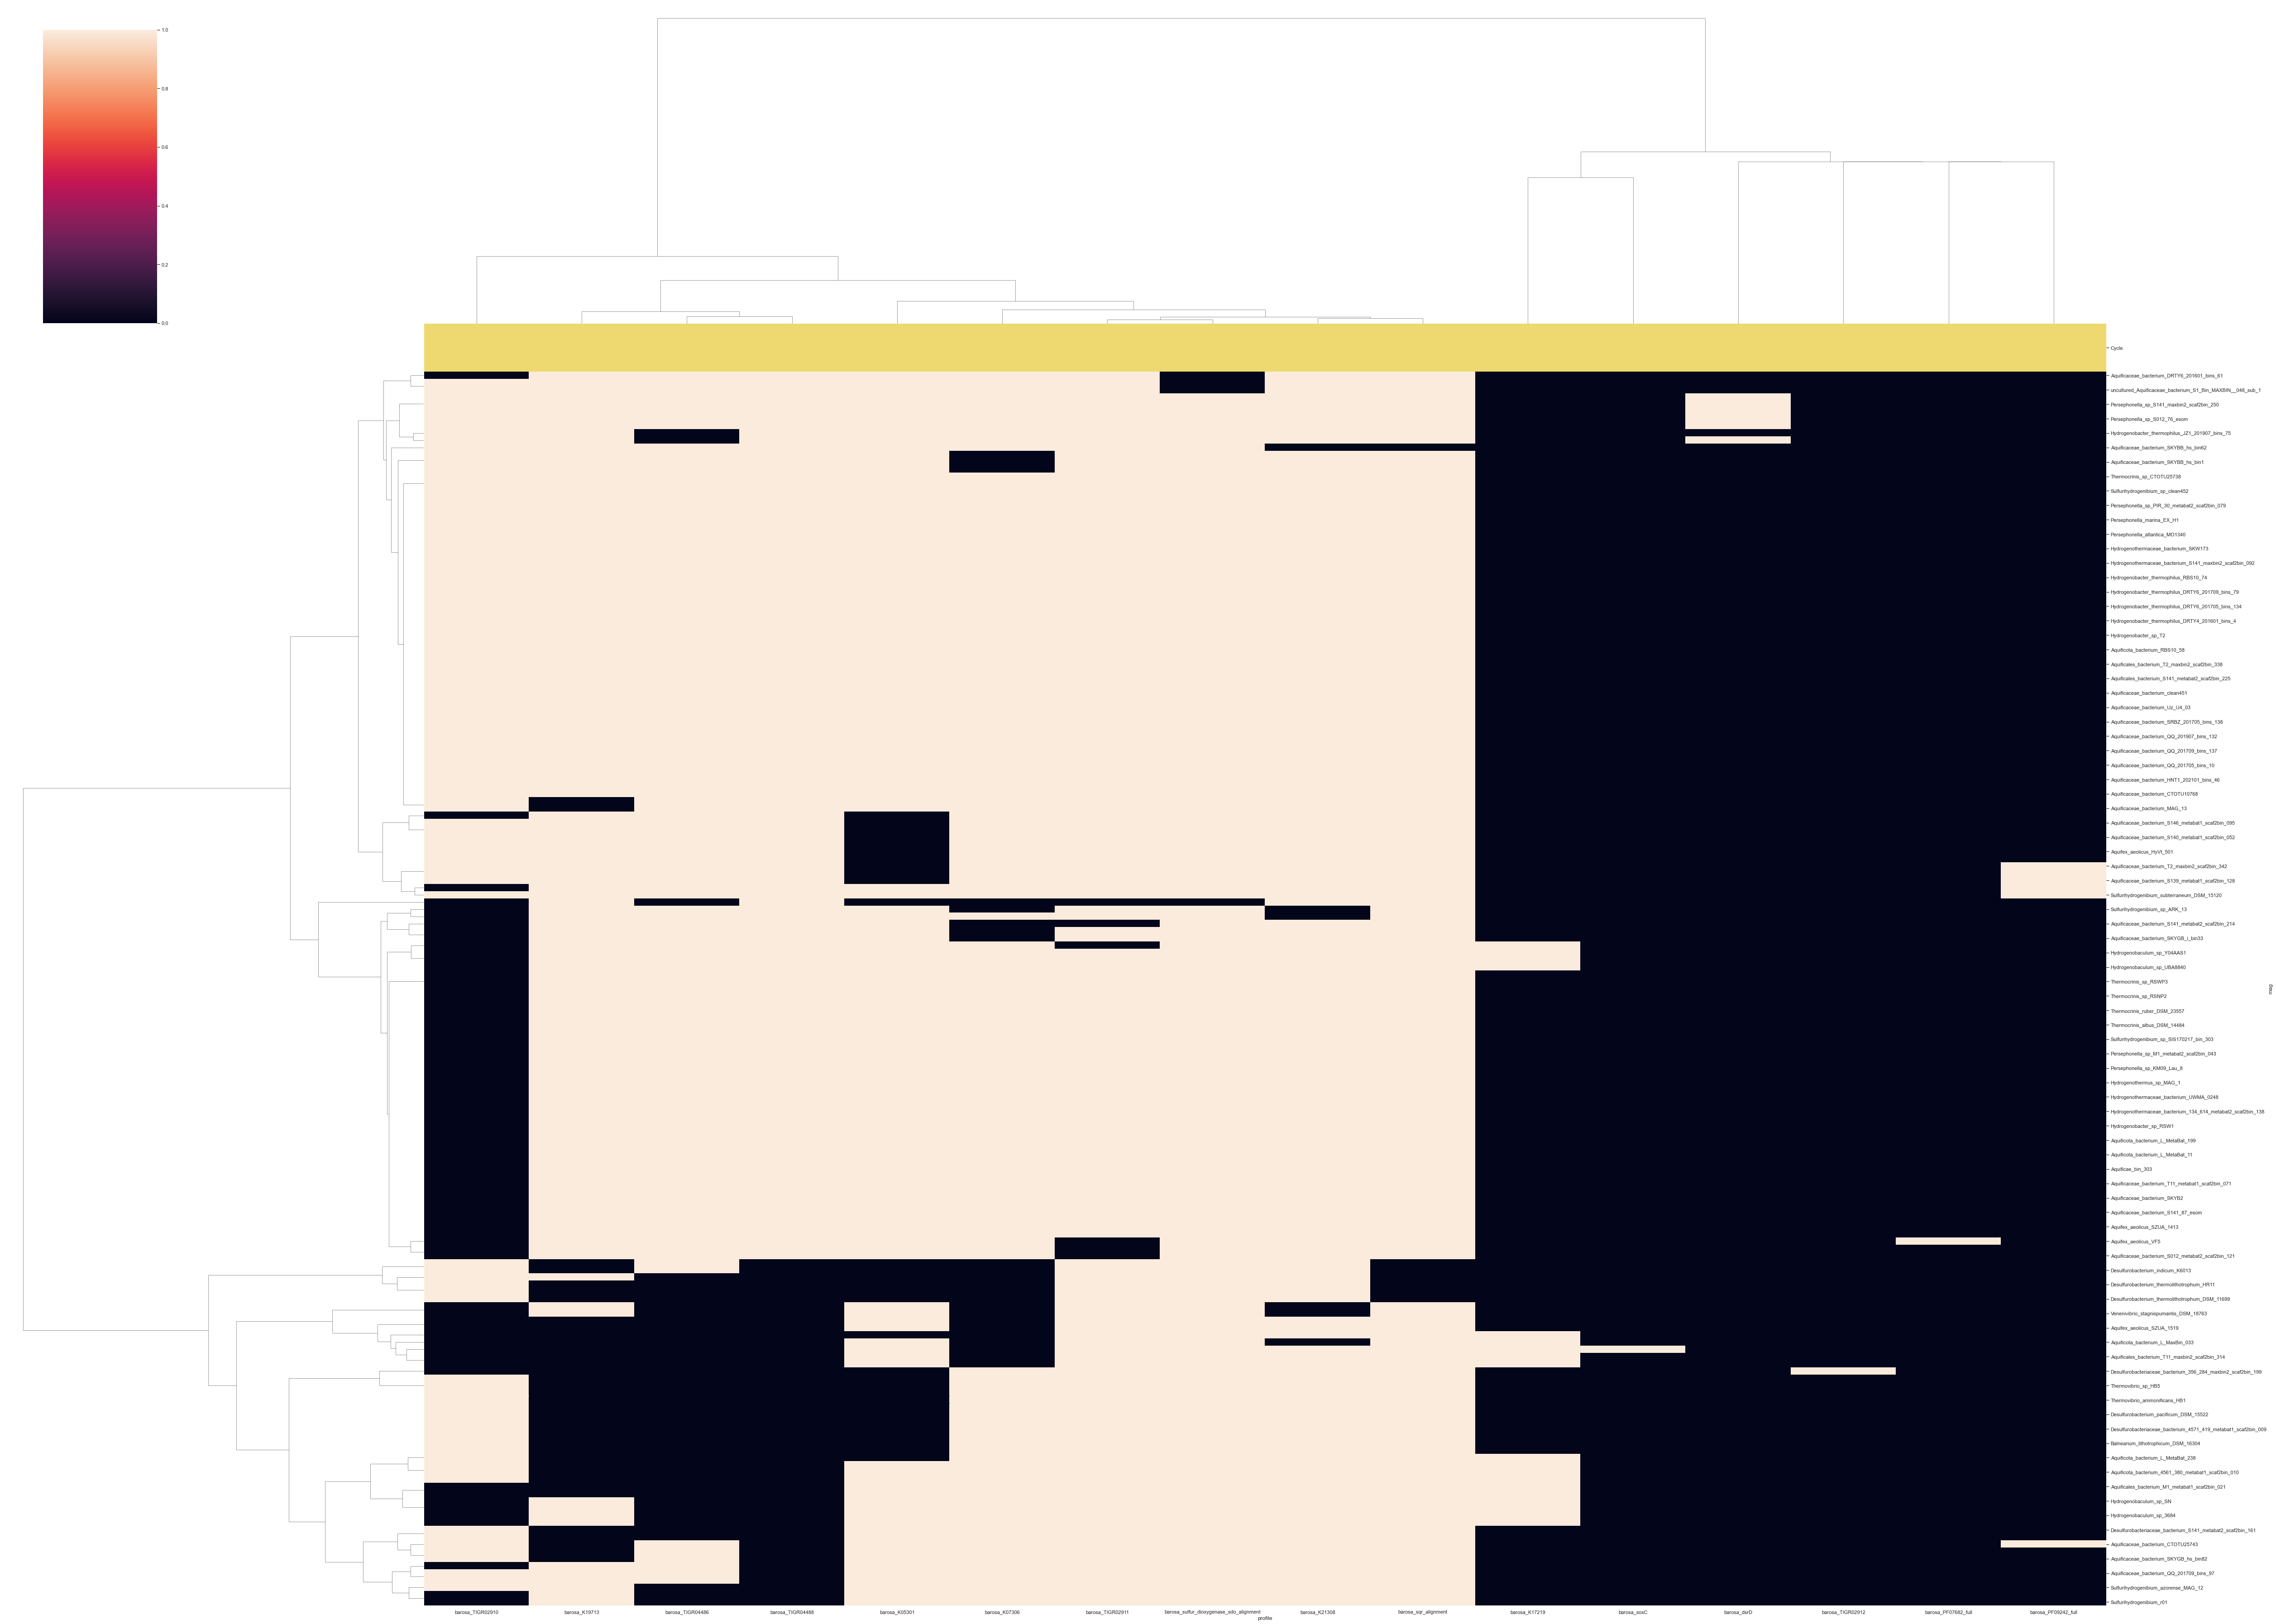

[+] Clustermap for cycle Transporters


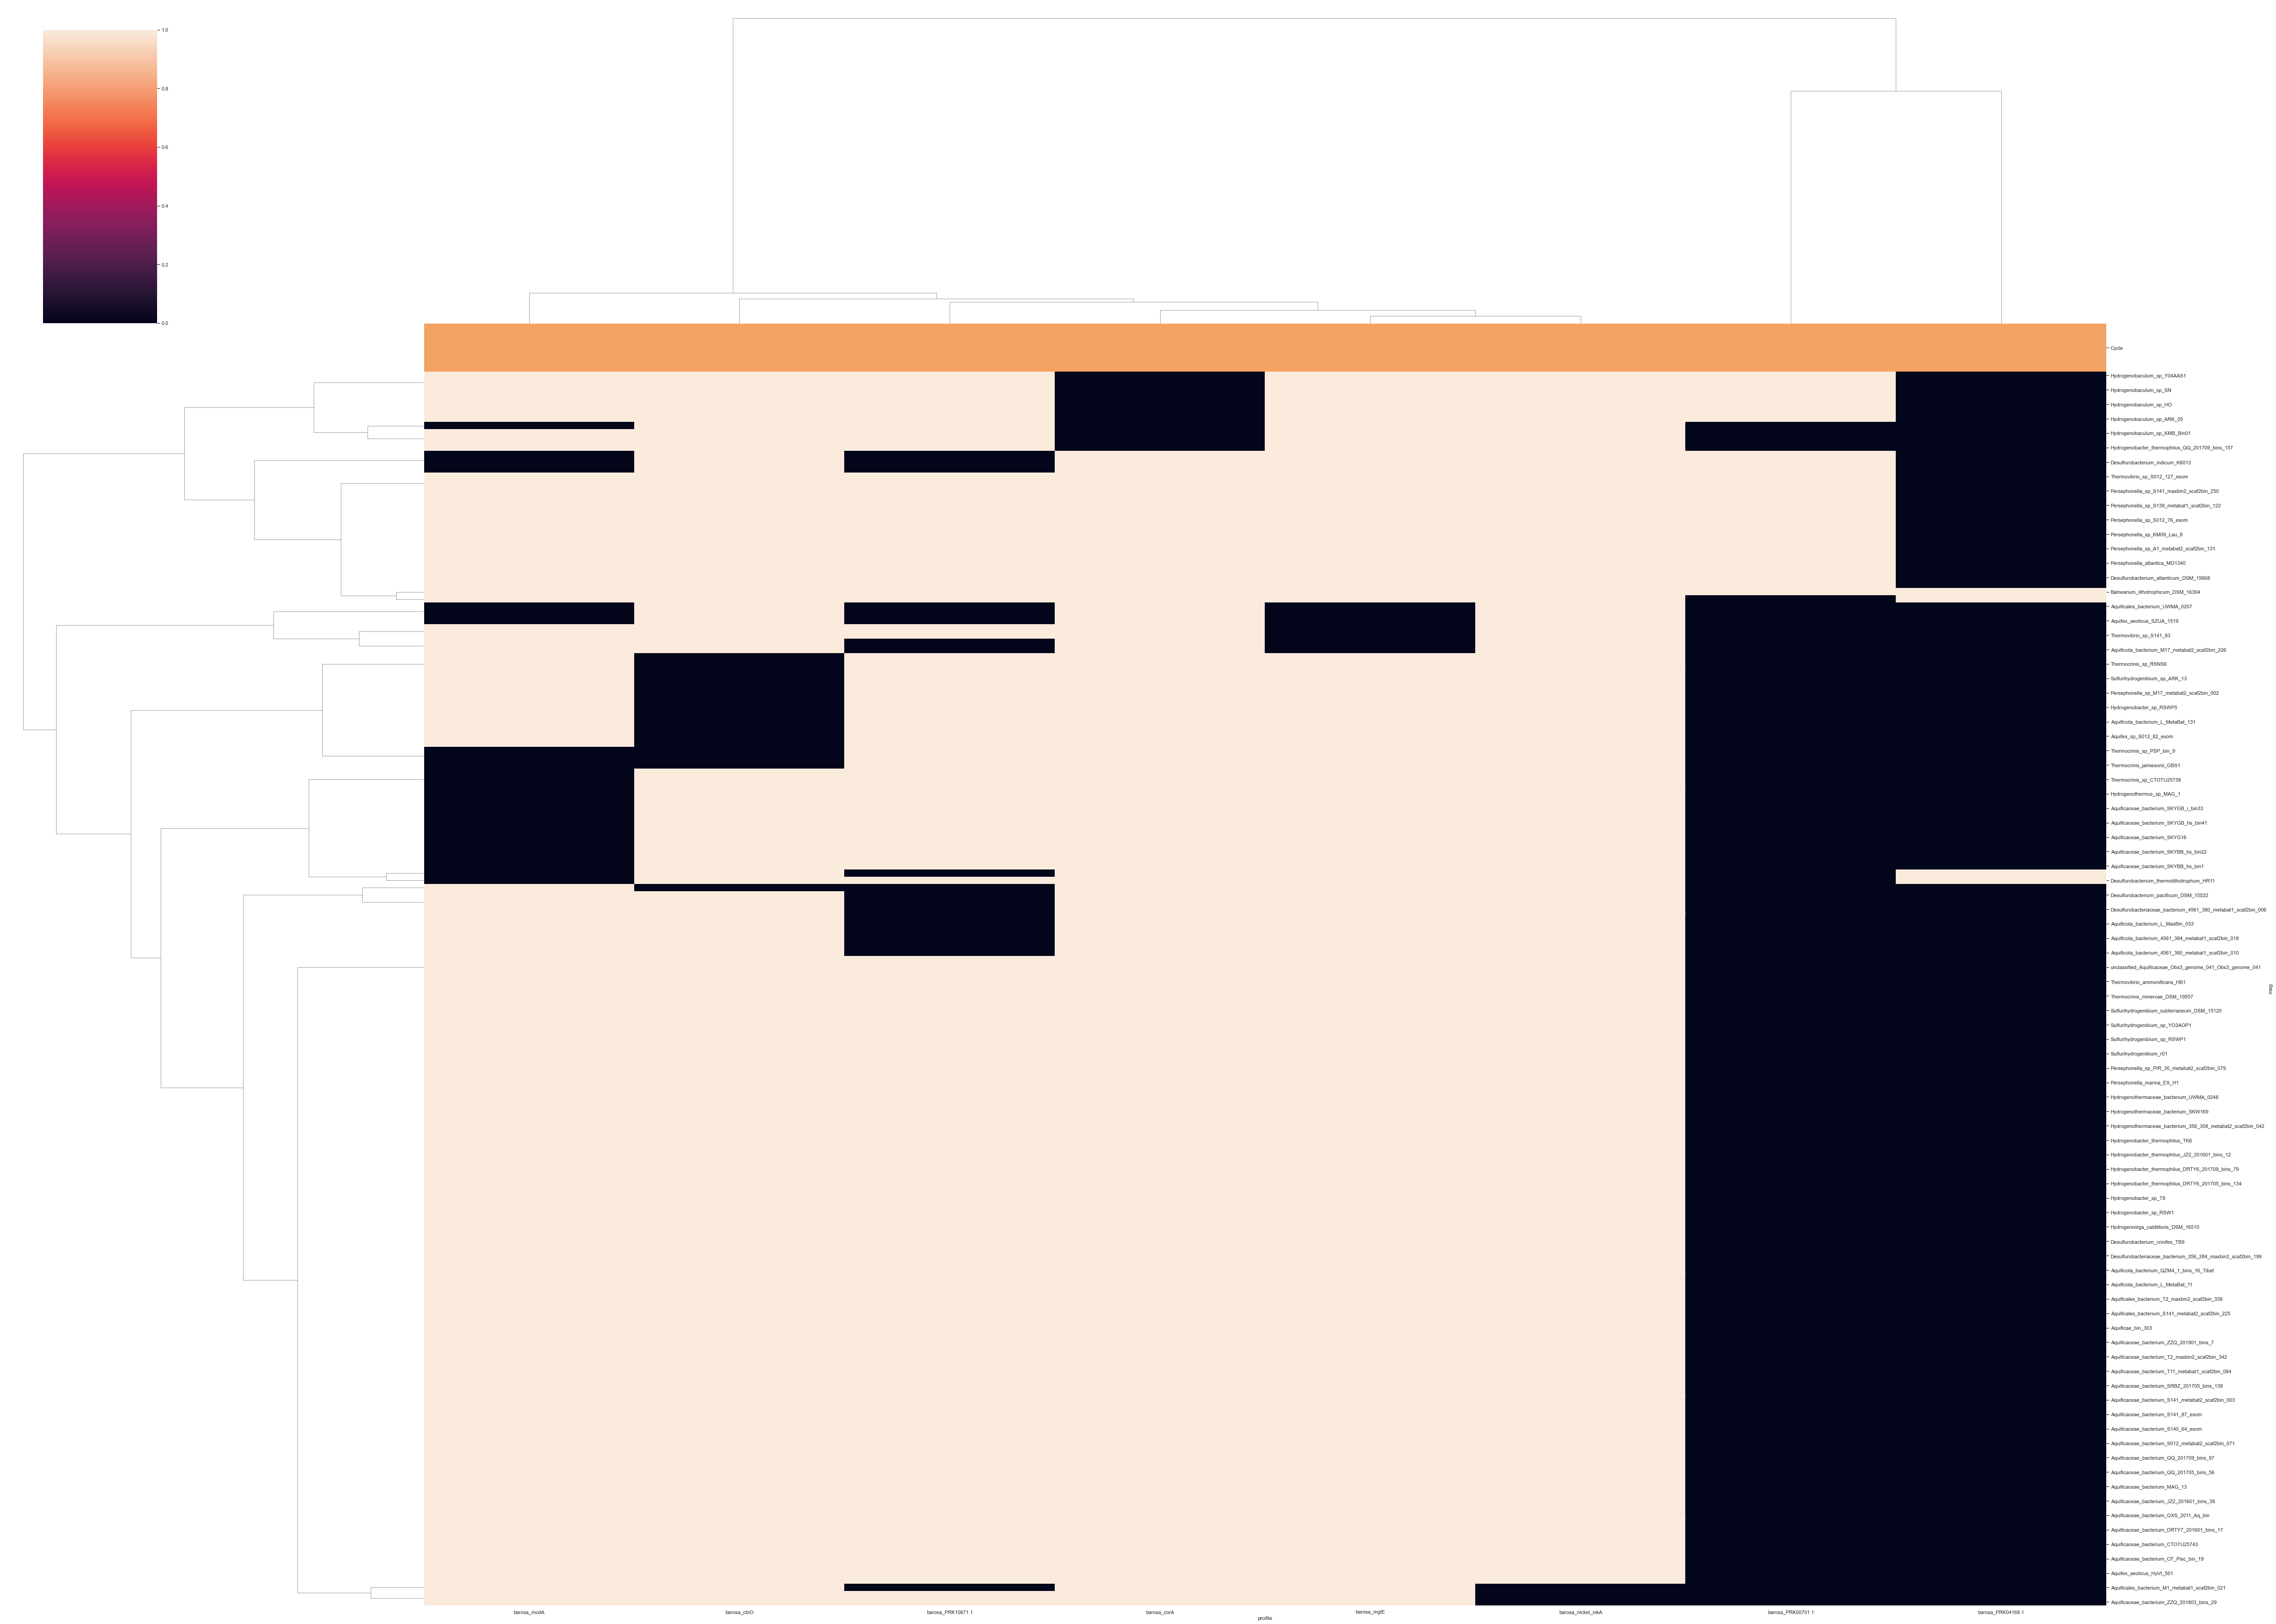

[+] Clustermap for cycle Hydrogen


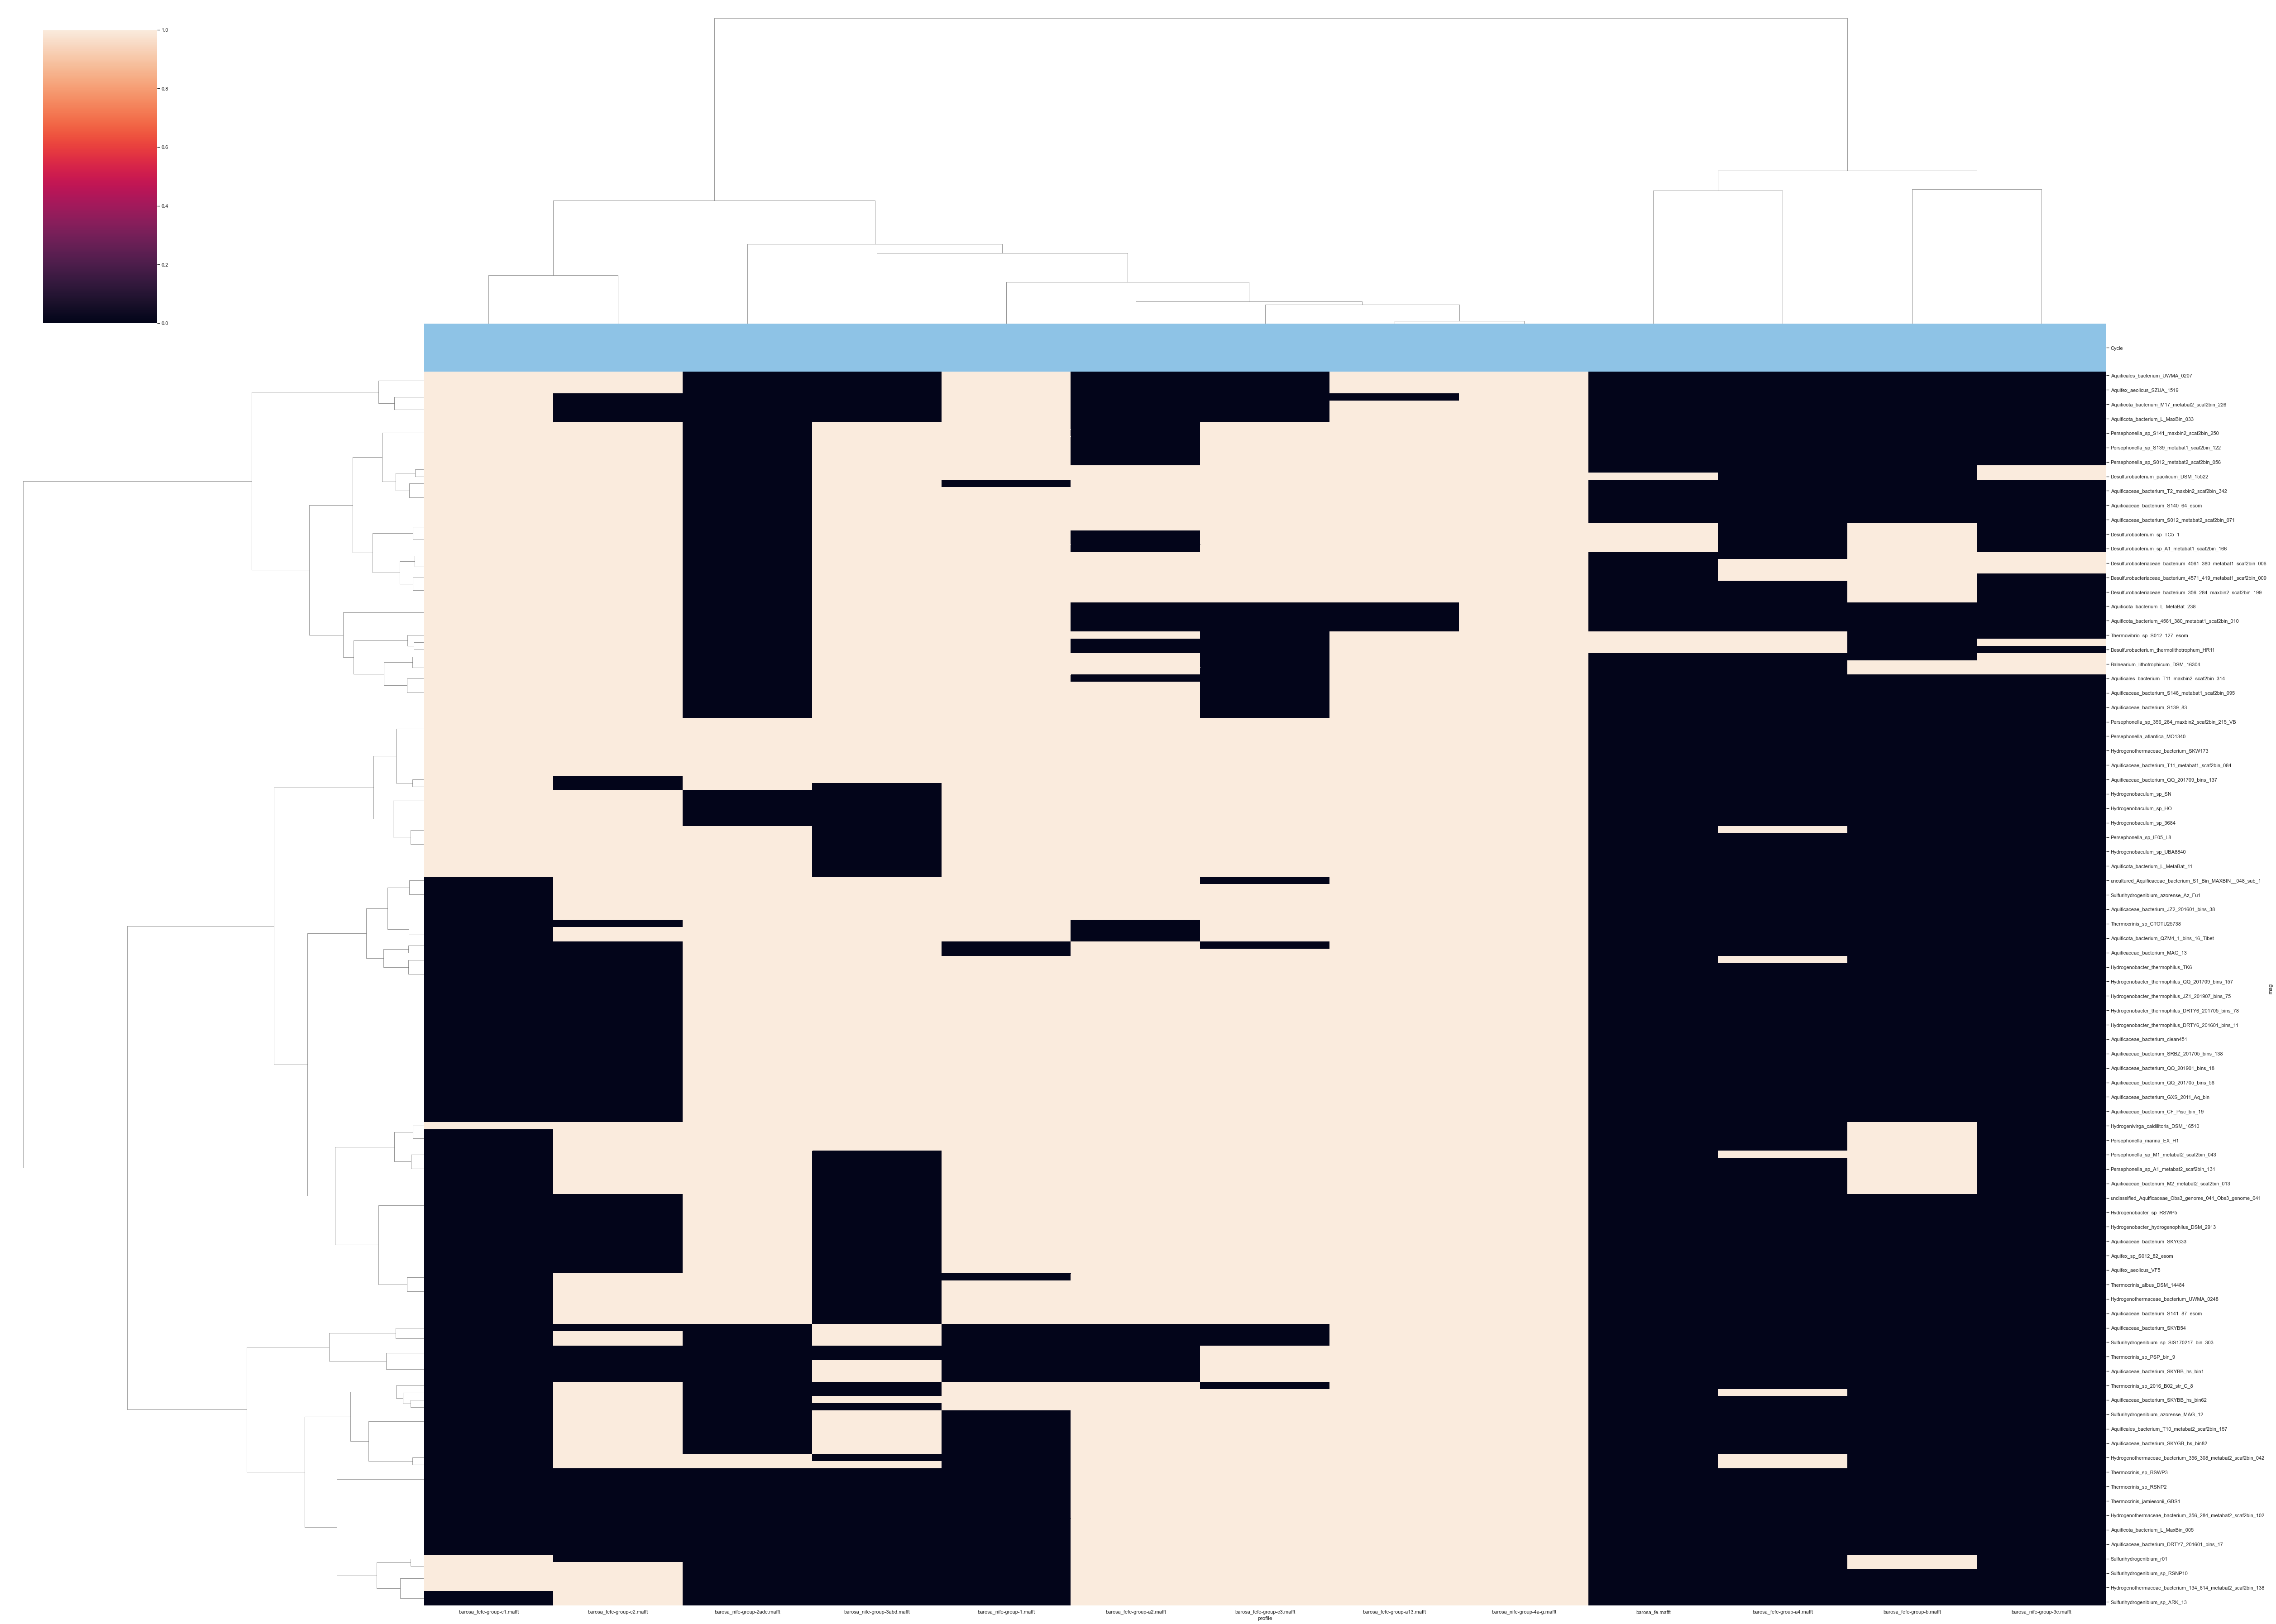

[+] Clustermap for cycle Selenium
[ERROR] Could not create clustermap for cycle Selenium: NaN dissimilarity value.
[+] Clustermap for cycle Iron


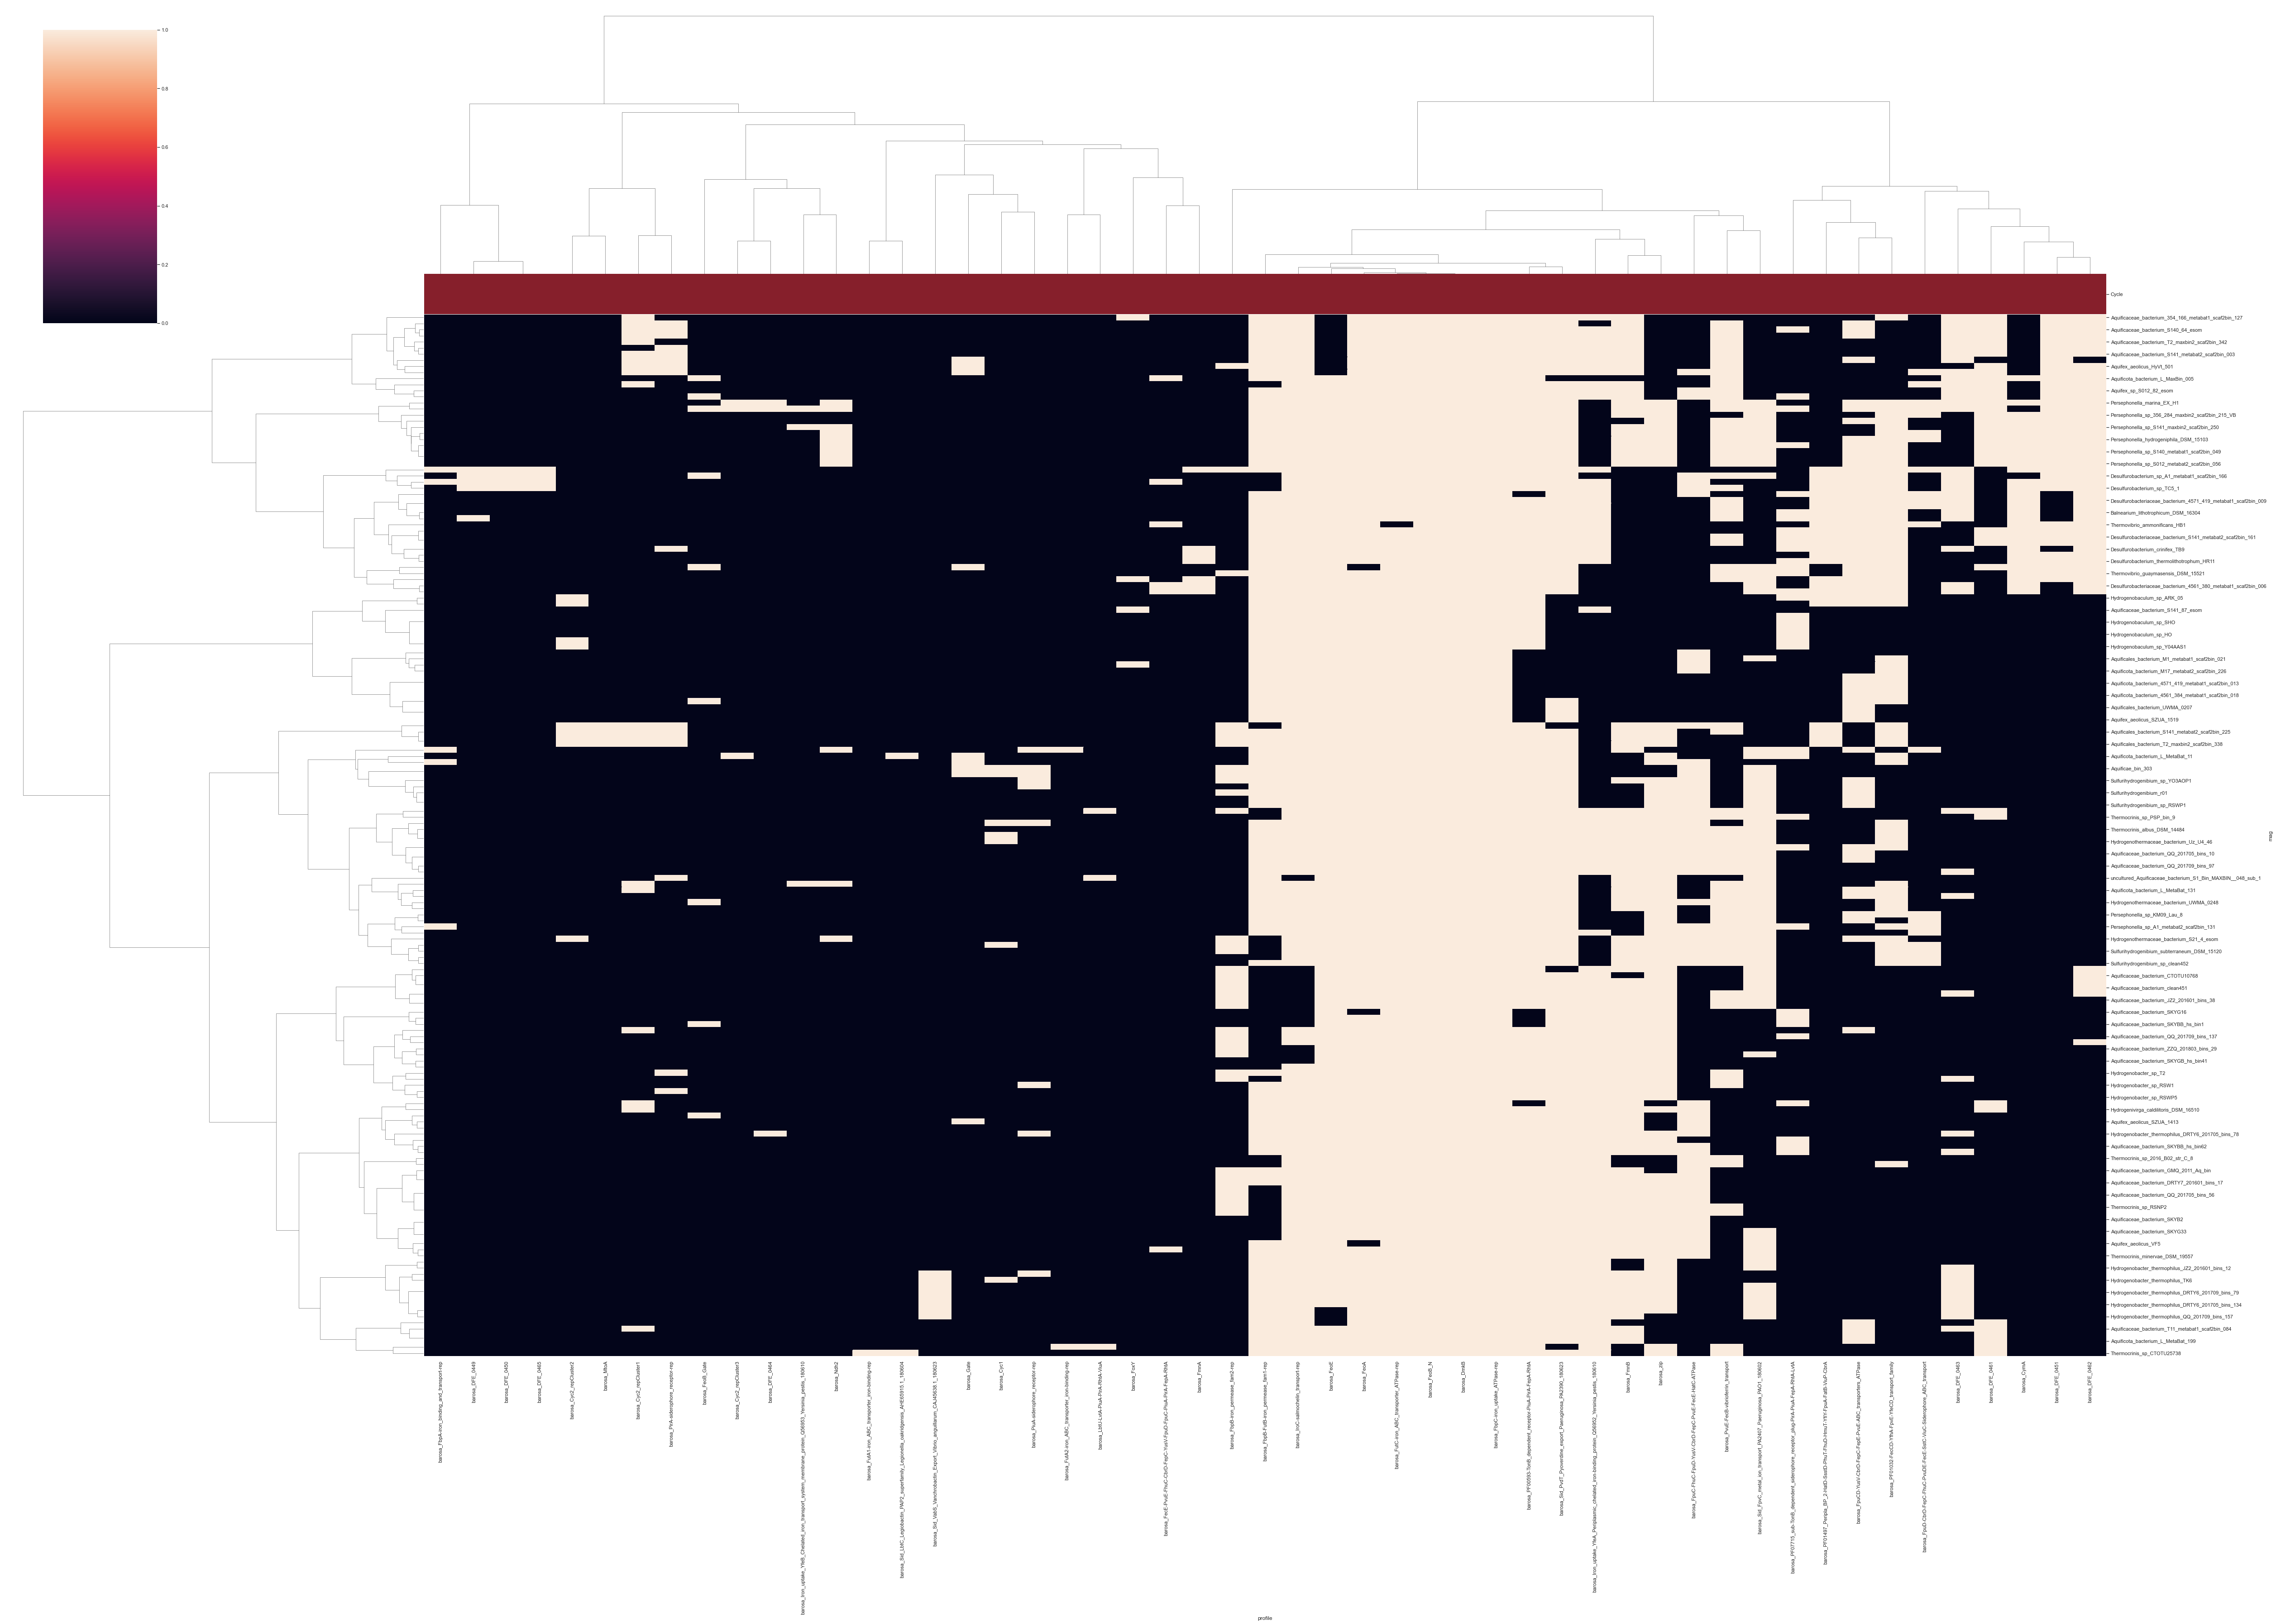

In [25]:
sns.set(font_scale=1.0)

for cycle in metadata_df["Cycle"].unique():

    cycle_hmm_models = metadata_df[
        metadata_df["Cycle"] == cycle
    ]["hmm_model"].unique()

    heat_df_cycle = heat_df[[
        col for col in heat_df.columns
        if col in cycle_hmm_models
    ]]

    try:
        print(f"[+] Clustermap for cycle {cycle}")
        sns.clustermap(
            data=heat_df_cycle,
            method=CLUSTERMAP_METHOD,
            metric=CLUSTERMAP_METRIC,
            col_colors=cycle_colors,
            figsize=(70, 50)
        )
        plt.savefig(
            os.path.join(
                DATA_DIR,
                f"heatmap-{'-'.join(SOURCES)}-cycle-{cycle.lower()}.svg"
            ),
            # dpi=300
        )
        plt.show()

    except Exception as error:
        print(f"[ERROR] Could not create clustermap for cycle {cycle}:", error)
        plt.close()


## HMM importance

In [16]:
X = heat_df.copy()

# Get families in the same order as in heat_df
y = tax_df.set_index("Genomes").loc[heat_df.index]["Family"]

# Encode as categories
family_mapping = {family: idx for idx, family in enumerate(y.unique())}
y = y.map(family_mapping)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_SEED
)

In [17]:
estimator = RandomForestClassifier(
    n_estimators=5,
    random_state=RANDOM_SEED
)
estimator.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=666)

In [18]:
print(family_mapping)
print()
print(
    classification_report(
        y_true=y_test,
        y_pred=estimator.predict(X_test)
    )
)

{'Aquificaceae': 0, 'QOAS01': 1, 'Hydrogenothermaceae': 2, 'Desulfurobacteriaceae': 3}

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.80      1.00      0.89         4
           2       1.00      0.83      0.91        12
           3       1.00      1.00      1.00         6

    accuracy                           0.96        52
   macro avg       0.94      0.96      0.95        52
weighted avg       0.97      0.96      0.96        52



In [19]:

result = permutation_importance(
    estimator,
    X_test,
    y_test,
    n_repeats=20,
    random_state=RANDOM_SEED,
    n_jobs=-1
)

forest_importances = pd.DataFrame({
        "feature": X_test.columns,
        "mean": result.importances_mean,
        "std": result.importances_std
}).sort_values("mean", ascending=False)

fig = px.bar(
    data_frame=forest_importances,
    x="feature",
    y="mean",
    error_y="std",
    labels={
        "feature": "HMM model",
        "mean": "Mean accuracy decrease",
        "std": "Mean accuracy decrease (std)"
    },
    title="HMM model importances",
    template="plotly_white",
    height=900
)
fig.show()